# Copula based Multivariate Series Forecasting 

In [731]:
# imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from arch import arch_model
from arch.univariate import ZeroMean
from collections import OrderedDict

In [47]:
# plot resolution
mpl.rcParams['figure.dpi'] = 200
# plot inline
%matplotlib inline

In [2]:
# load data (takes 1 minute)
data_df = pd.read_csv("train.csv")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data_df.head()

id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN

# Selecting a forecasting Target

## Sales per city

Our goal here is to extract some interesting time series. We'll then perform some mutltivariate forecasting using a copula based model.
We want to reduce variablity within the series. Thus, we can start by looking at sales level for each city in the set.

In [157]:
# compute total sales per store
groups_store = data_df['unit_sales'].groupby(data_df['store_nbr'])
total_sales_per_store = groups_store.apply(pd.DataFrame.sum)

In [158]:
# load store metadata
stores_df = pd.read_csv('stores.csv')
# store all possible cities
cities = list(map(str, stores_df['city'].unique()))
# results dataframe
total_sales_per_city = pd.DataFrame(index=cities, columns=['total sales'])

In [159]:
stores_df.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [160]:
cities[:5]

['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba']

In [161]:
# group stores by city
group_city = stores_df['store_nbr'].groupby(stores_df['city'])
for group in group_city:
    city_name = group[0]
    city_total_sales = total_sales_per_store.loc[group[1].values].values.sum()
    total_sales_per_city.loc[city_name, 'total sales'] = city_total_sales

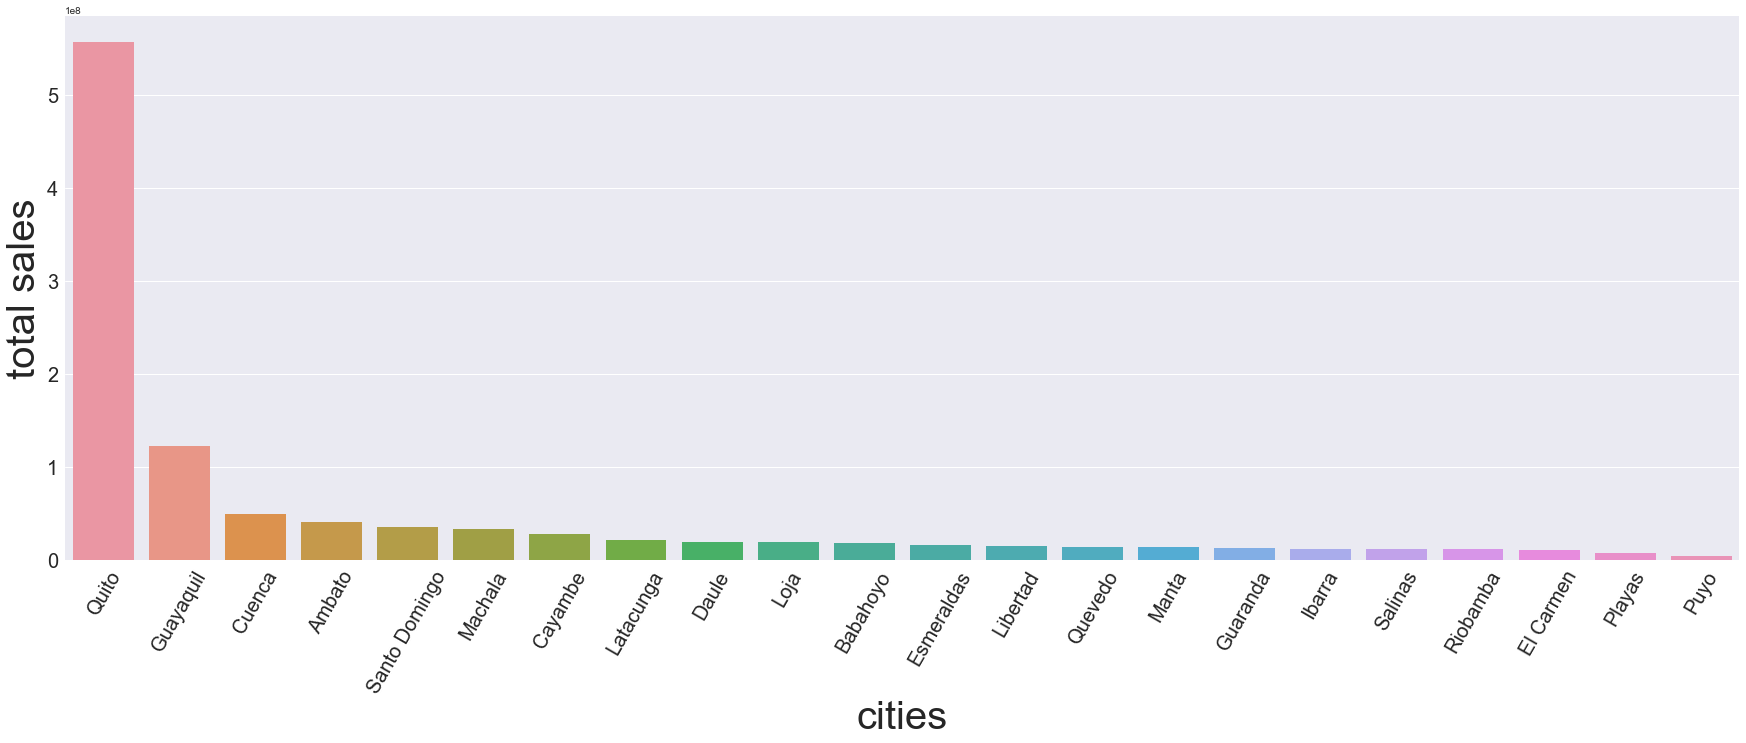

In [293]:
# sort and plot results
total_sales_per_city_srtd = total_sales_per_city.sort_values(by='total sales', ascending=False)
plt.figure(figsize=(30, 10))
sns.barplot(x=total_sales_per_city_srtd.index, y='total sales', data=total_sales_per_city_srtd)
plt.ylabel('total sales', fontsize=40)
plt.xlabel('cities', fontsize=40)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=60);

Given the large amount of data available in the capital Quito, we will only look at stores that are in that town. That will reduce the part of variability related to location.

## Sales per product category in Quito stores

Let's look at the sale levels over the different product categories

In [168]:
# load items metadata
items_df = pd.read_csv('items.csv')

In [169]:
items_df.head()

item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1

In [174]:
# store all possible categories
cat = list(map(str, items_df['family'].unique()))
# results dataframe
total_sales_per_cat = pd.DataFrame(index=cat, columns=['total sales'])

In [175]:
# group stores by category
group_cat = items_df['item_nbr'].groupby(items_df['family'])
for group in group_cat:
    cat_name = group[0]
    cat_total_sales = total_sales_per_item.loc[group[1].values].values.sum()
    total_sales_per_cat.loc[cat_name, 'total sales'] = cat_total_sales

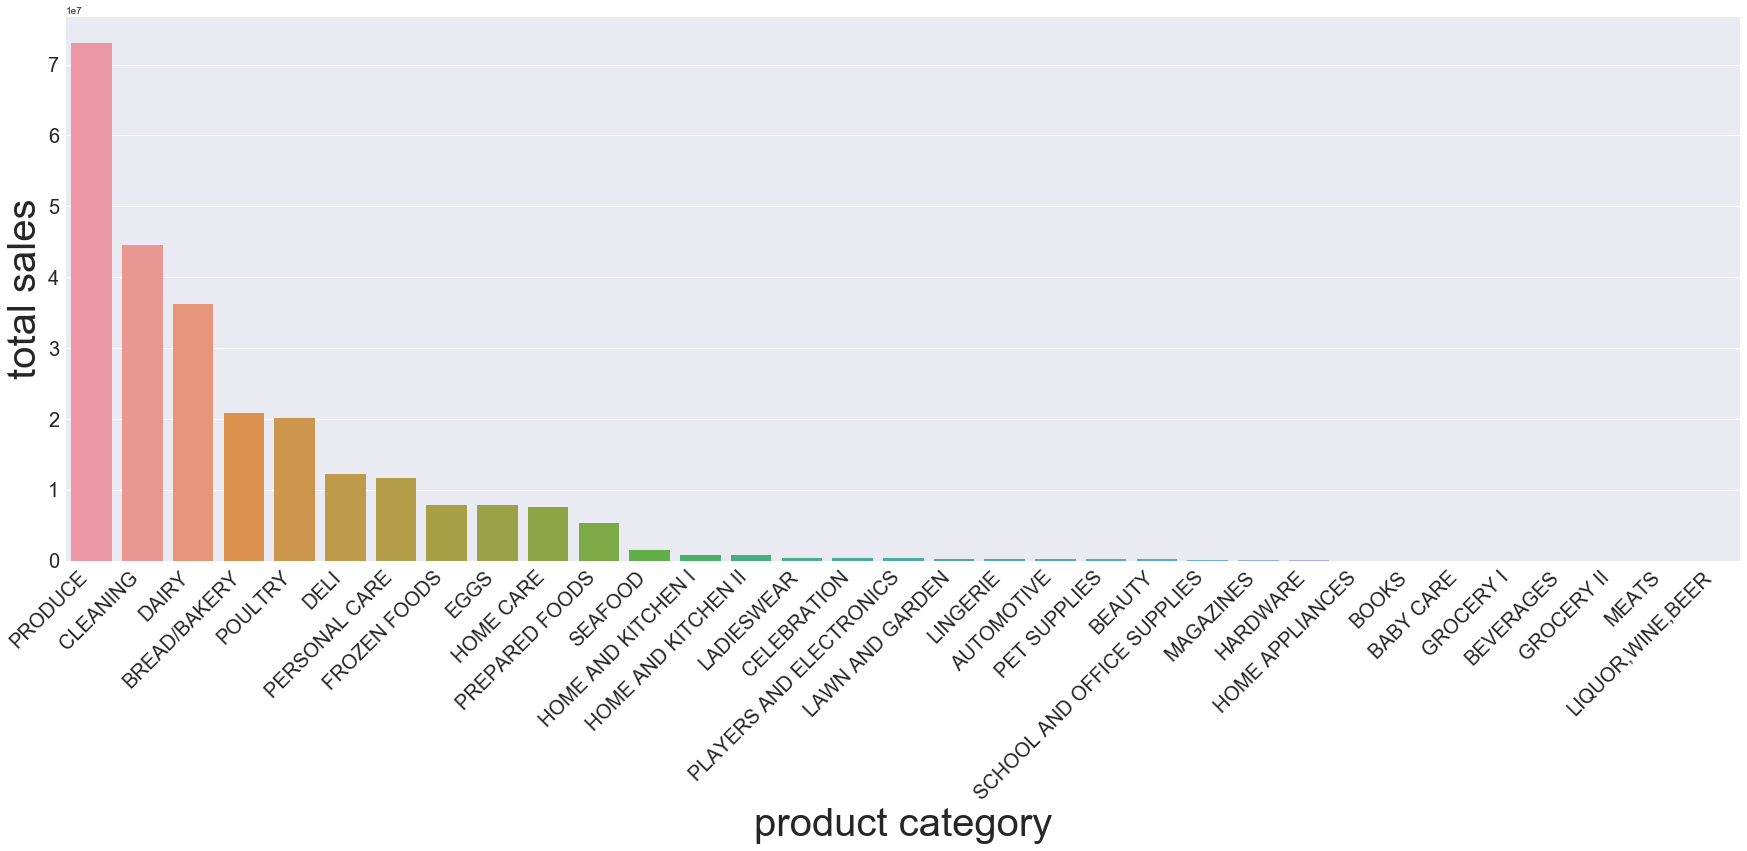

In [199]:
# sort and plot results
total_sales_per_cat_srtd = total_sales_per_cat.sort_values(by='total sales', ascending=False)
plt.figure(figsize=(30, 10))
sns.barplot(x=total_sales_per_cat_srtd.index, y='total sales', data=total_sales_per_cat_srtd)
plt.ylabel('total sales', fontsize=40)
plt.xlabel('product category', fontsize=40)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.set_xticklabels(total_sales_per_cat_srtd.index, fontsize=20, rotation=45, ha='right', minor=False);

## Sales per item in Quito stores (FYI, not used in our approach)

We also assume the following assertion: the higher the sale number the more likely the item will be sold everyday. Thus, let's look for the best sellers within the items available in Quito

In [163]:
# get rid of data related to stores outside of Quito (20 seconds to run)
relevant_stores = group_city.get_group('Quito').values
data_df_quito = data_df.loc[data_df['store_nbr'].isin(relevant_stores)]

In [164]:
# group by item id
groups_item = data_df_quito['unit_sales'].groupby(data_df_quito['item_nbr'])

In [165]:
# comput total sales per item
total_sales_per_item = groups_item.apply(pd.DataFrame.sum)

In [166]:
# put in dataframe for plotting purposes
total_sales_per_item = pd.DataFrame(total_sales_per_item, columns=['unit_sales'])
total_sales_per_item_srtd = total_sales_per_item.sort_values(by='unit_sales', ascending=False)

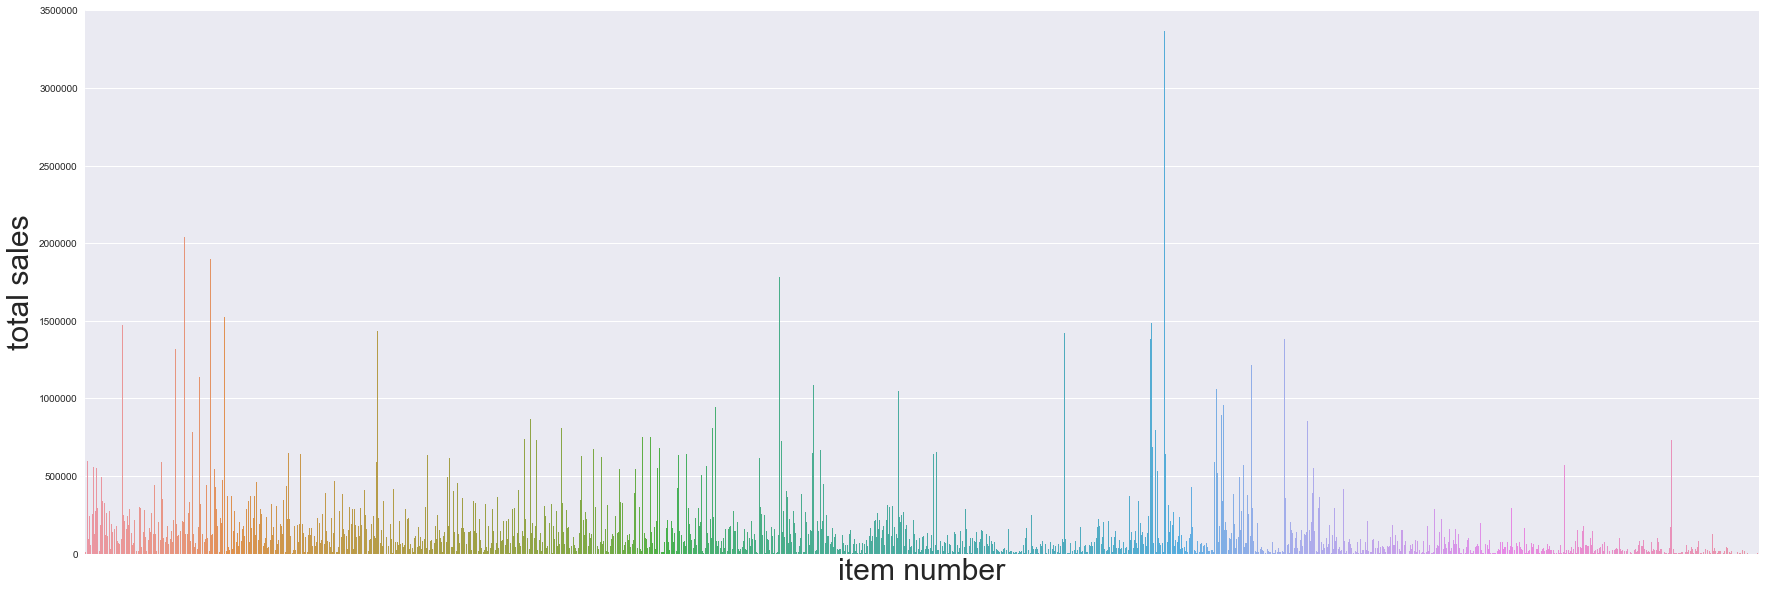

In [167]:
# plot sales per item (more than one minute to run)
plt.figure(figsize=(30, 10))
sns.barplot(x=total_sales_per_item.index, y='unit_sales', data=total_sales_per_item);
plt.ylabel('total sales', fontsize=30)
plt.xlabel('item number', fontsize=30)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') 
plt.ylim([0, 3500000]);

## Conclusion of exploration

We thought it might be interesting to take a closer look at the bad diet habits of Ecuadorians (e.g. bread and prepared foods). Following our selection logic we reduced the location spectrum of our data to the City of Quito.
To be perfectly clear, we will be working with a two-dimensional multivariate time series of which the components are daily sales for baked goods and daily sales for prepared foods.

# Isolating the series and OOS sample

First of all, let's isolate our data set from the rest of the available data.

In [278]:
# isolate frozen and prepared foods item nbrs
baked_items = group_cat.get_group('BREAD/BAKERY').values
prepared_items = group_cat.get_group('PREPARED FOODS').values

In [279]:
# isolate relevant data in quito dataframe ()
baked_data = data_df_quito.loc[data_df['item_nbr'].isin(baked_items)]
prepared_data = data_df_quito.loc[data_df['item_nbr'].isin(prepared_items)]

In [280]:
# quick look
baked_data.head(2)

id        date  store_nbr  item_nbr  unit_sales onpromotion
578  578  2013-01-02          1    103665         2.0         NaN
632  632  2013-01-02          1    153395         5.0         NaN

In [281]:
# group item sales by date and sum
dates_group_baked = baked_data['unit_sales'].groupby(baked_data['date'])
date_sales_baked = dates_group_baked.apply(pd.DataFrame.sum)
date_sales_baked.index = pd.DatetimeIndex(date_sales_baked.index)
dates_group_prepared = prepared_data['unit_sales'].groupby(prepared_data['date'])
date_sales_prepared = dates_group_prepared.apply(pd.DataFrame.sum)
date_sales_prepared.index = pd.DatetimeIndex(date_sales_prepared.index)

In [282]:
# quick look
date_sales_baked.head(2)

date
2013-01-02    13654.836
2013-01-03     8899.648
Name: unit_sales, dtype: float64

In [283]:
# santity check: check that the date range is the same and if there is any missing data
date_range = pd.date_range(start=baked_data['date'].min(), end=baked_data['date'].max())
dates_baked = date_sales_baked.index
dates_prepared = date_sales_prepared.index
missing_dates_baked = date_range.difference(date_range.intersection(dates_baked))
missing_dates_prepared = date_range.difference(date_range.intersection(dates_prepared))
print("Missing dates for baked foods : " + ", ".join(str(d.date()) for d in missing_dates_baked))
print("Missing dates for prepared foods : " + ", ".join(str(d.date()) for d in missing_dates_prepared))

Missing dates for baked foods : 2013-12-25, 2014-01-01, 2014-12-25, 2015-01-01, 2015-12-25, 2016-01-01, 2016-12-25, 2017-01-01
Missing dates for prepared foods : 2013-12-25, 2014-01-01, 2014-12-25, 2015-01-01, 2015-12-25, 2016-01-01, 2016-12-25, 2017-01-01


It appears that data is missing on christmas day and january first of each year.
That kind of obvious "seasonality" isn't interesting to study so we'll interpolate to get rid of them. For prediction purposes we'll want to set those numbers to zero if the problematic dates appear in our prediction set.
Finally, we can isolate our two time series.

In [284]:
# the two series
baked_series = date_sales_baked.reindex(date_range).interpolate()
prepared_series = date_sales_prepared.reindex(date_range).interpolate()

In [285]:
# check interpolation
dates = ['2013-12-24', '2013-12-25', '2013-12-26']
baked_series.loc[baked_series.index.isin(dates)]

2013-12-24    6424.007
2013-12-25    7342.983
2013-12-26    8261.959
Freq: D, Name: unit_sales, dtype: float64

In order to be able to perform some Out Of Sample evaluation of our model we are going to keep an untouched sample in the variable "category"_oos.

In [620]:
# OOS sample
split_idx = int(np.floor(0.8 * len(date_range)))
baked_train, baked_oos = baked_series.iloc[:split_idx], baked_series.iloc[split_idx:] 
prepared_train, prepared_oos = prepared_series.iloc[:split_idx], prepared_series.iloc[split_idx:] 

# Modeling Margins

Now that we have both our series at disposal we can start our modeling effort. 
The idea behind the usage of copulas can be resumed in the following "equation":
\begin{equation}
"copula + margins = distribution"
\end{equation}
That is to say we can study a multivariate distribution by separately looking at the margins then their dependence structure through the associated copula.
In this section we are going to model our two margins.

Thanks to an adptation of Slark's theorem by A.J. Patton (Duke University) we can transfer copula methods to forecasting.
For visualization purposes and to get a first feel of our data, let's plot both of our series.

## Motivation phase

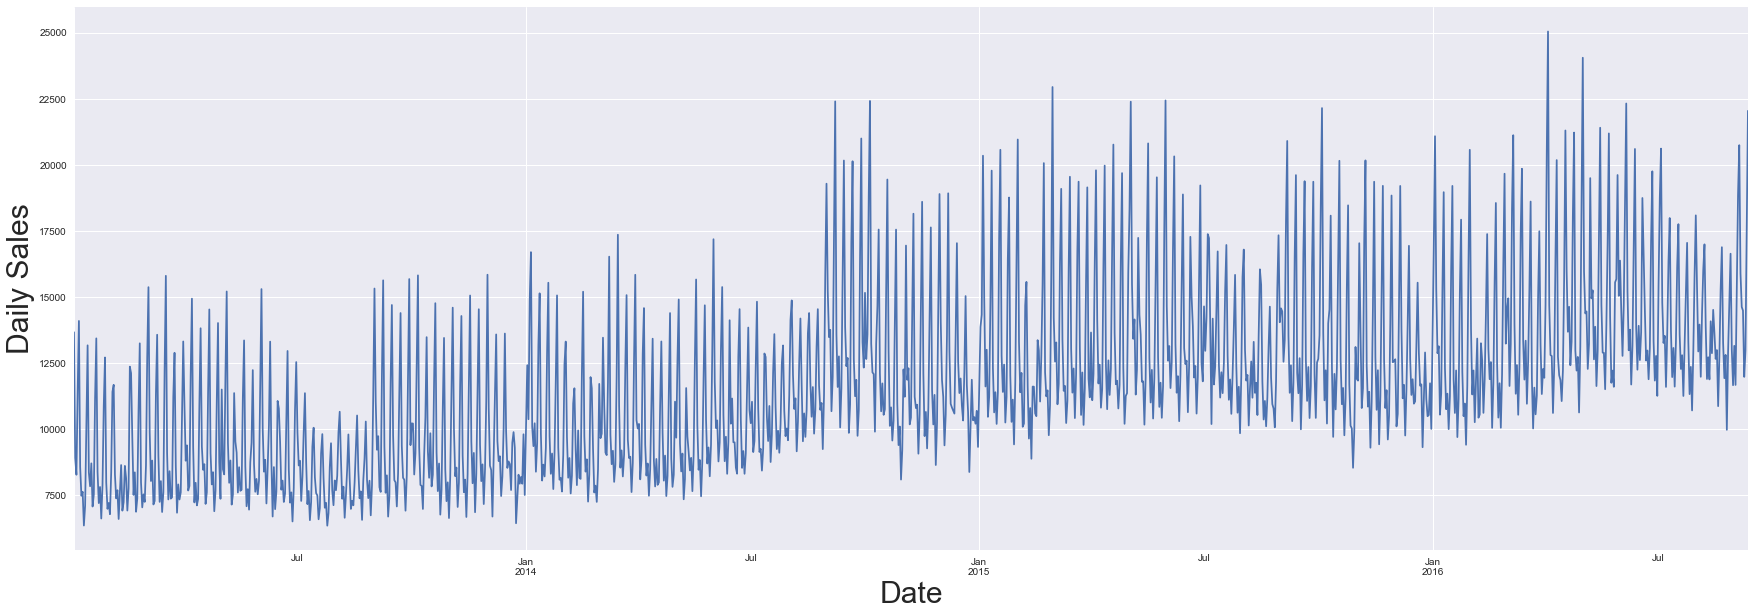

In [621]:
# frozen series plot
baked_train.plot(figsize=(30, 10))
plt.ylabel('Daily Sales', fontsize=30)
plt.xlabel('Date', fontsize=30);

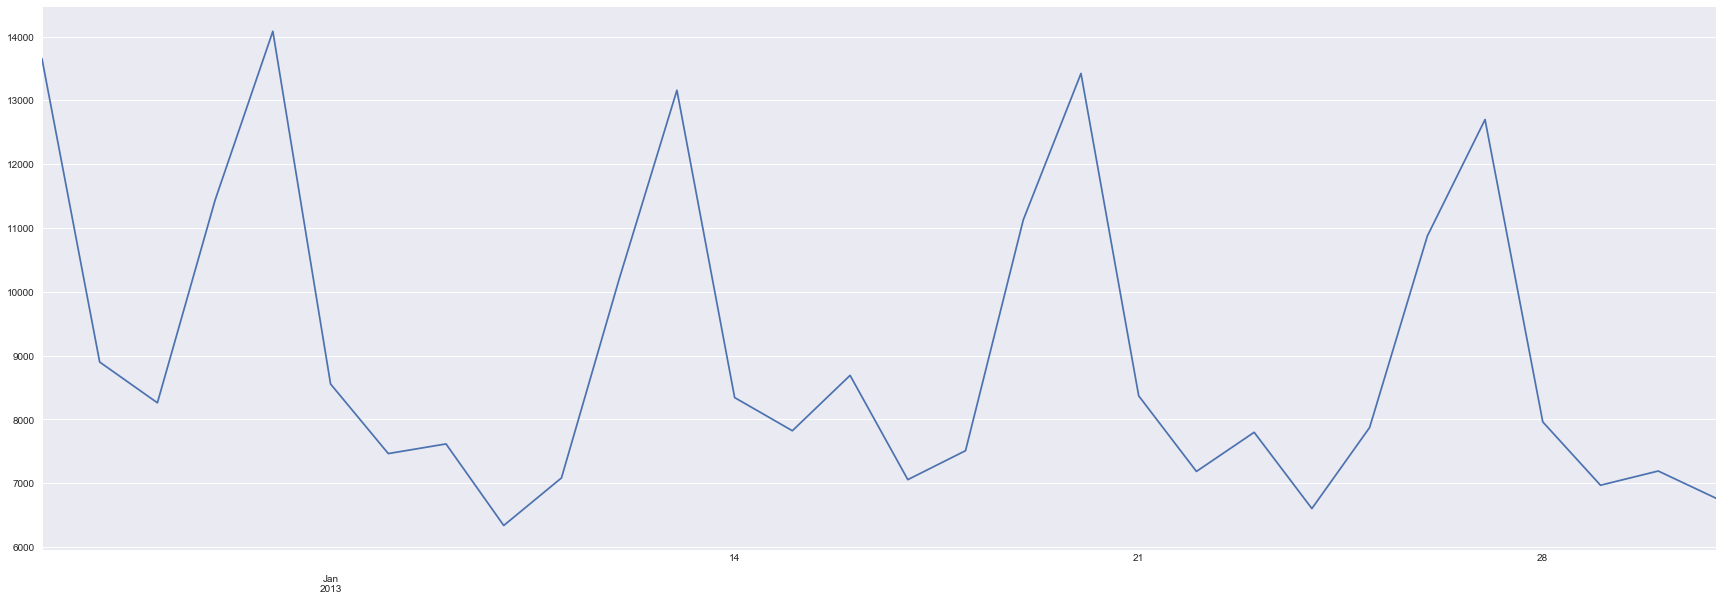

In [622]:
baked_train[:30].plot(figsize=(30, 10))

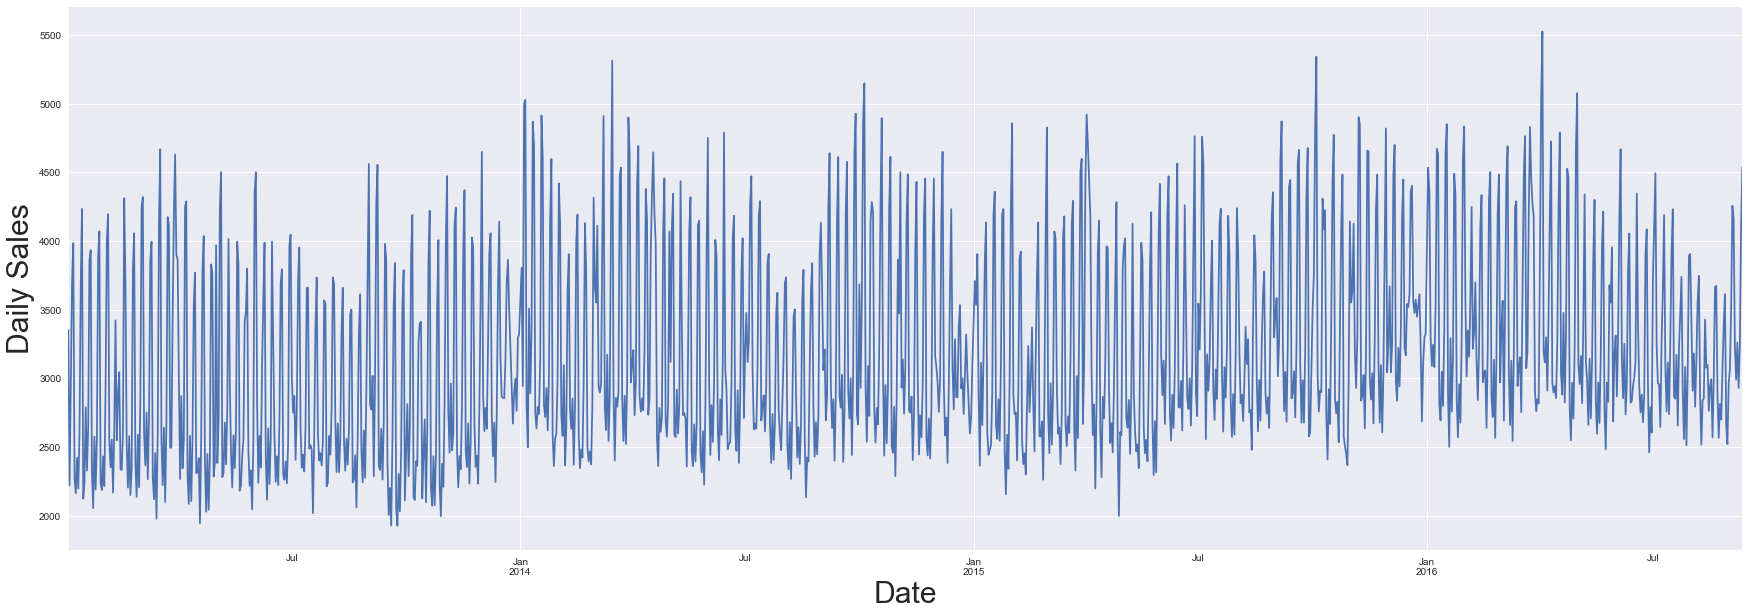

In [623]:
# prepared series plot
prepared_train.plot(figsize=(30, 10))
plt.ylabel('Daily Sales', fontsize=30)
plt.xlabel('Date', fontsize=30);

To estimate the pertinent orders we might consider for our models let's have a look at the (partial) Autocorrelation.
To do so we will use the python library statsmodels.
To look for weekly seasonality we'll also plot a zoomed area of each series.
We might as well as plot empirical quantiles vs theoretical quantiles plots (QQ plots) and probability plots.

In [624]:
def tsplot(y, lags=None, figsize=(30, 15), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (4, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        zoom_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (2, 1))
        qq_ax = plt.subplot2grid(layout, (3, 0))
        pp_ax = plt.subplot2grid(layout, (3, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots', fontsize=30)
        y[:30].plot(ax=zoom_ax)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot', fontsize=30)        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

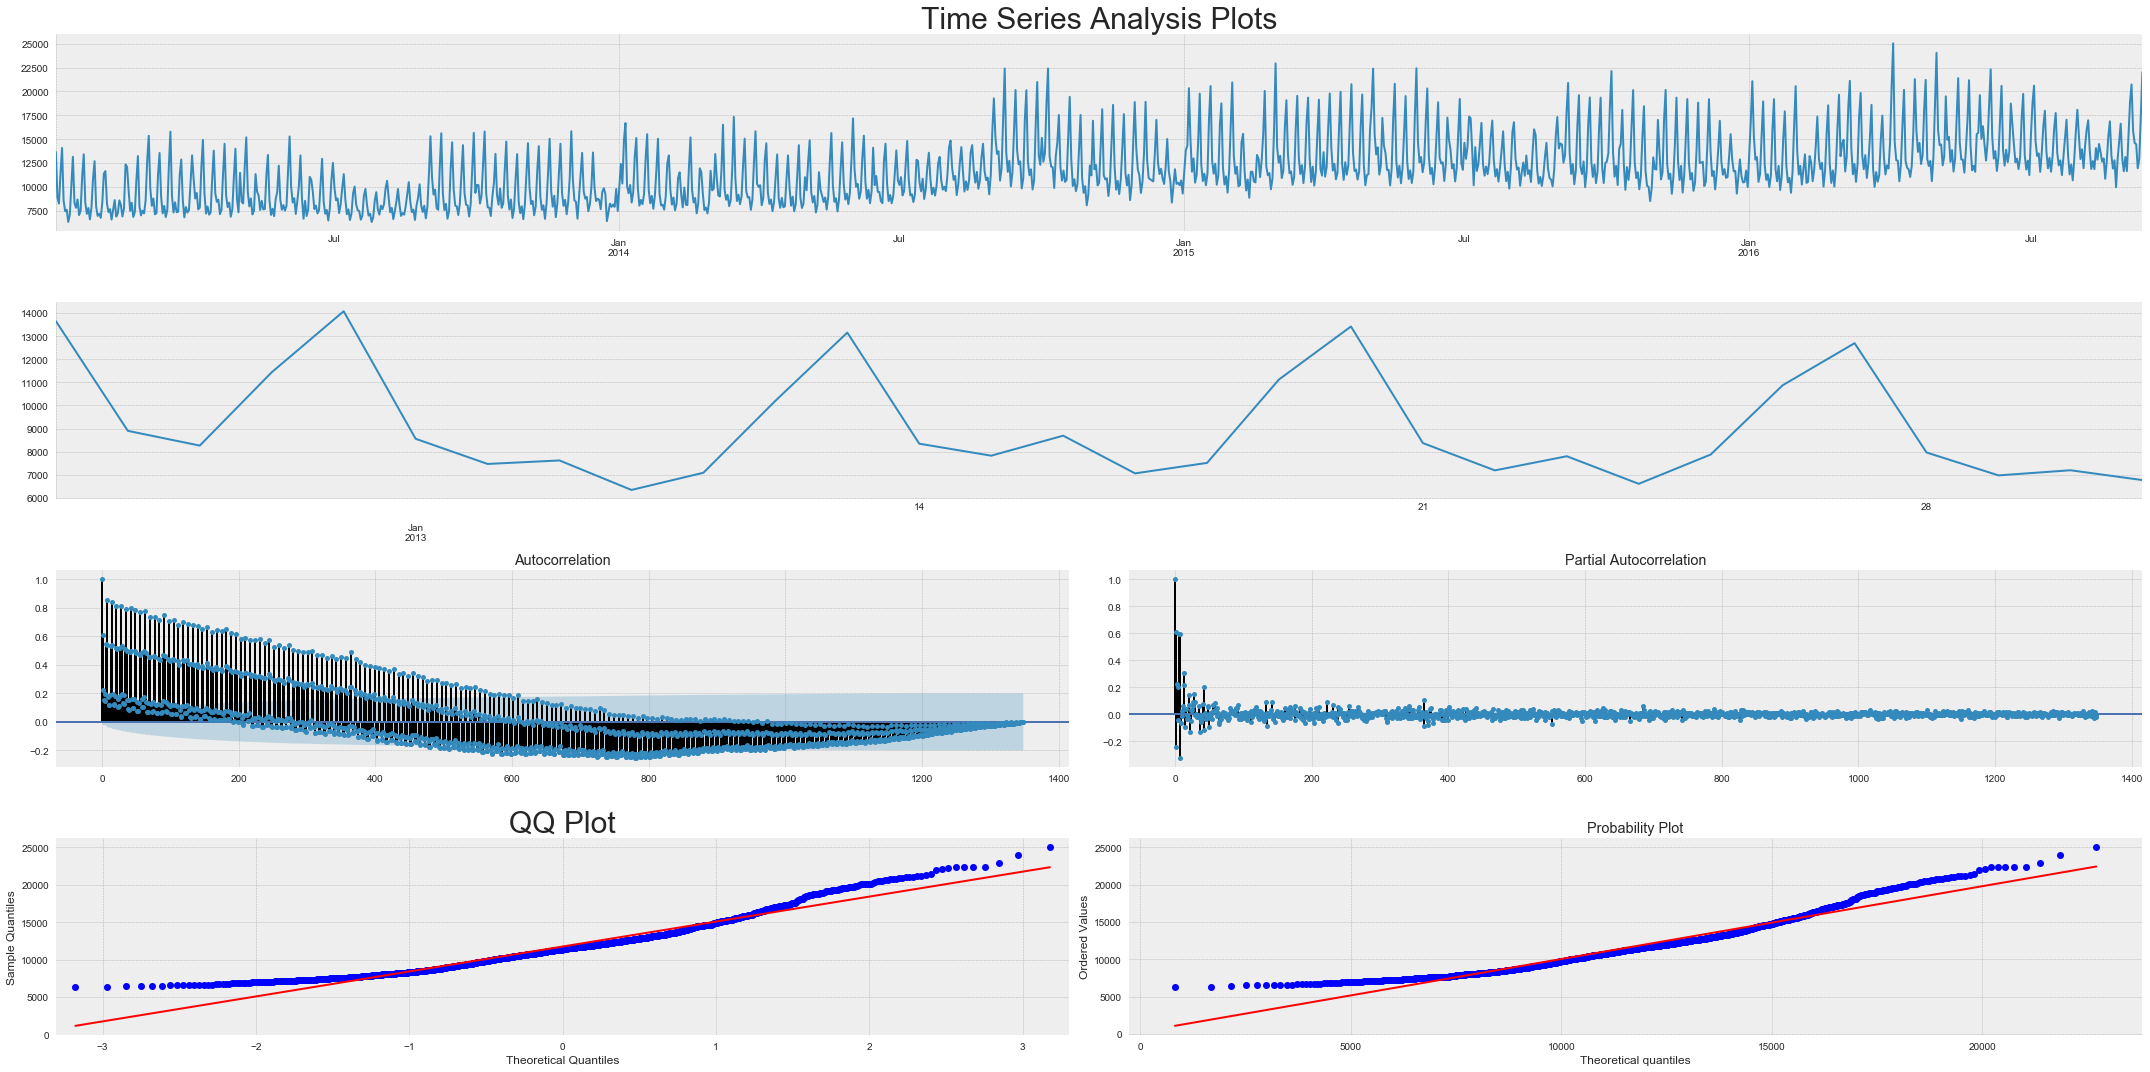

In [625]:
# all plots
tsplot(baked_train);

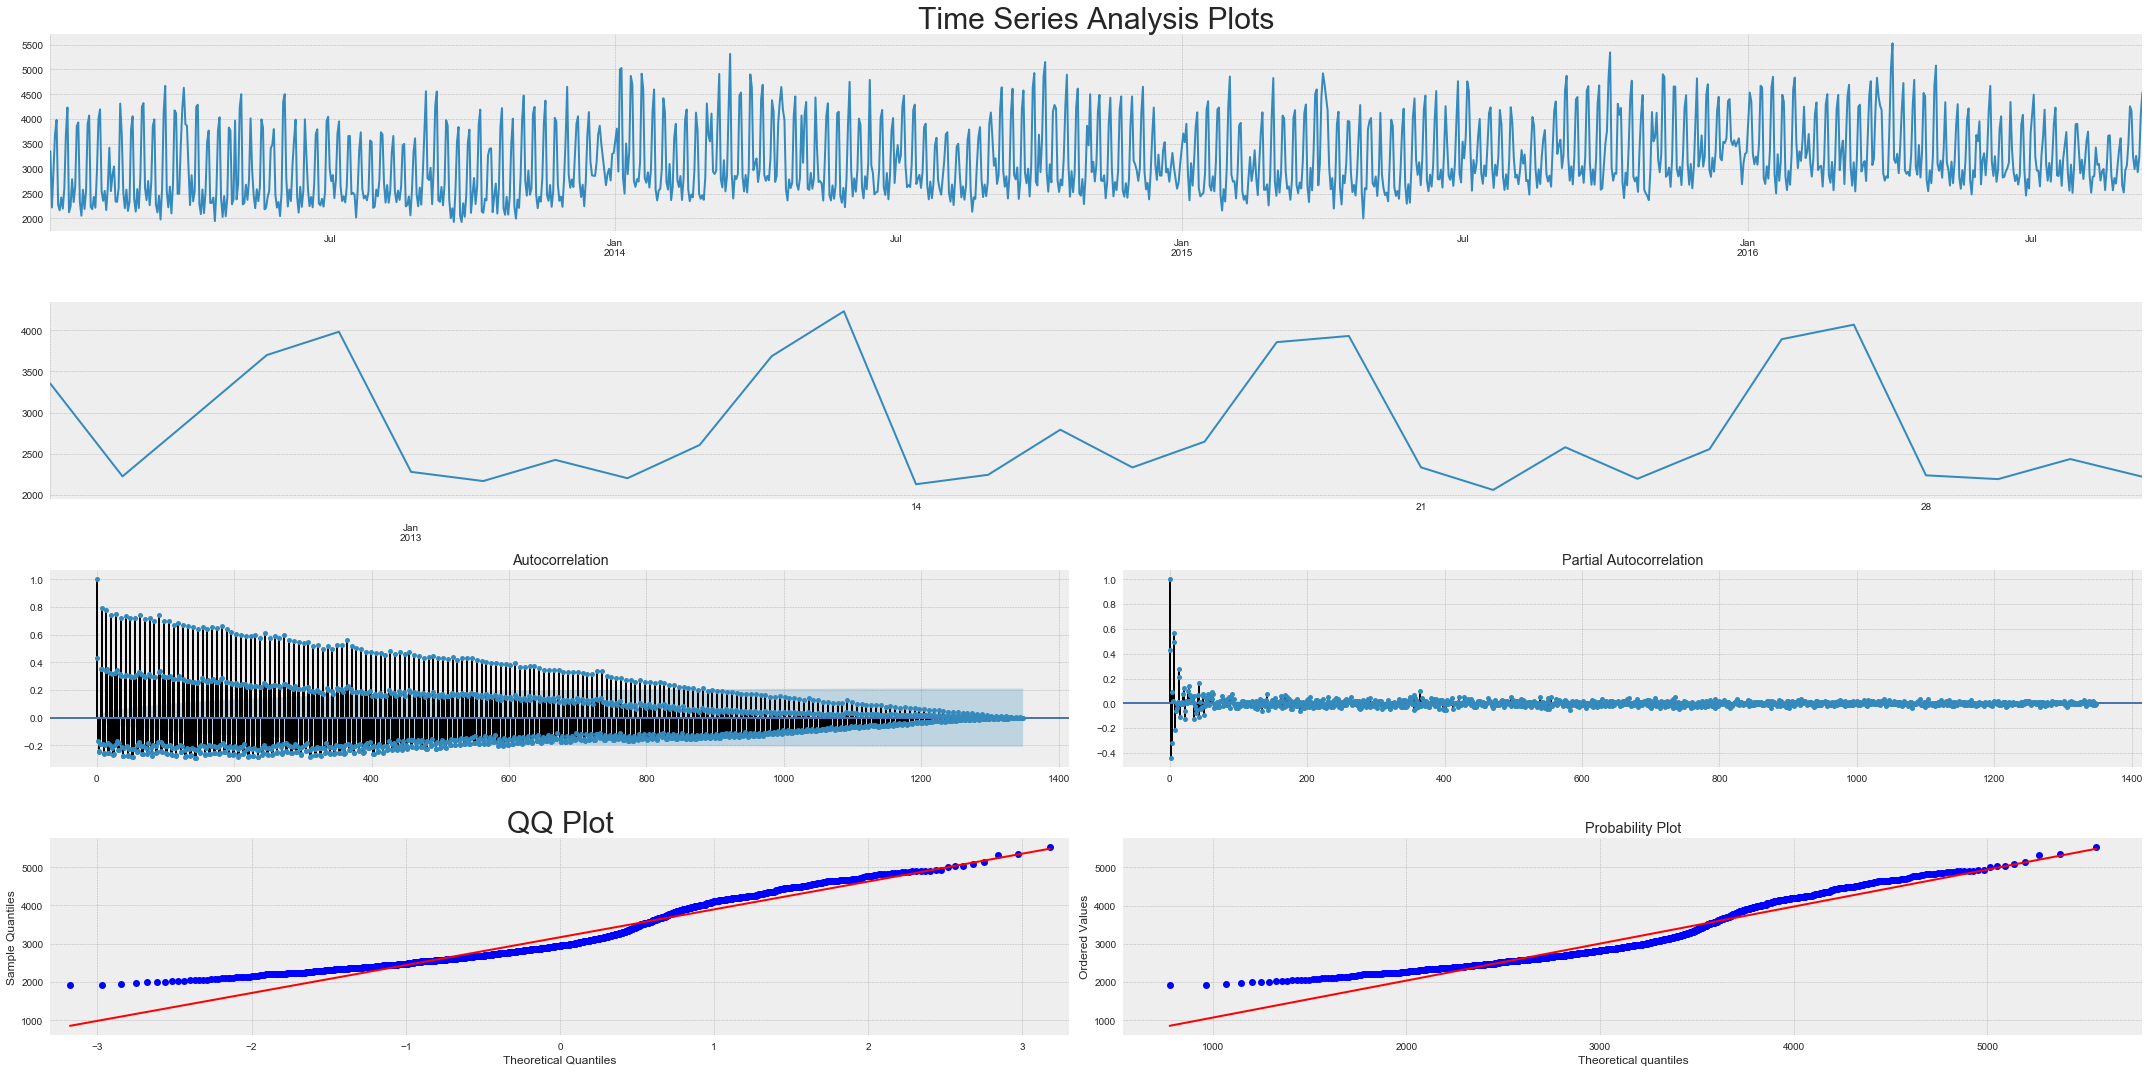

In [626]:
# all plots
tsplot(prepared_train);

In both cases, the zoomed out plots reveal very strong weekly seasonality.
That's not really interesting for us so we'll just get rid of it by resampling and looking at weekly sales levels.

In [627]:
# resampling
baked_train = baked_train.resample('W-MON').sum()
baked_oos = baked_oos.resample('W-MON').sum()
prepared_train = prepared_train.resample('W-MON').sum()
prepared_oos = prepared_oos.resample('W-MON').sum()

Let's draw our battery of standard plots once more.

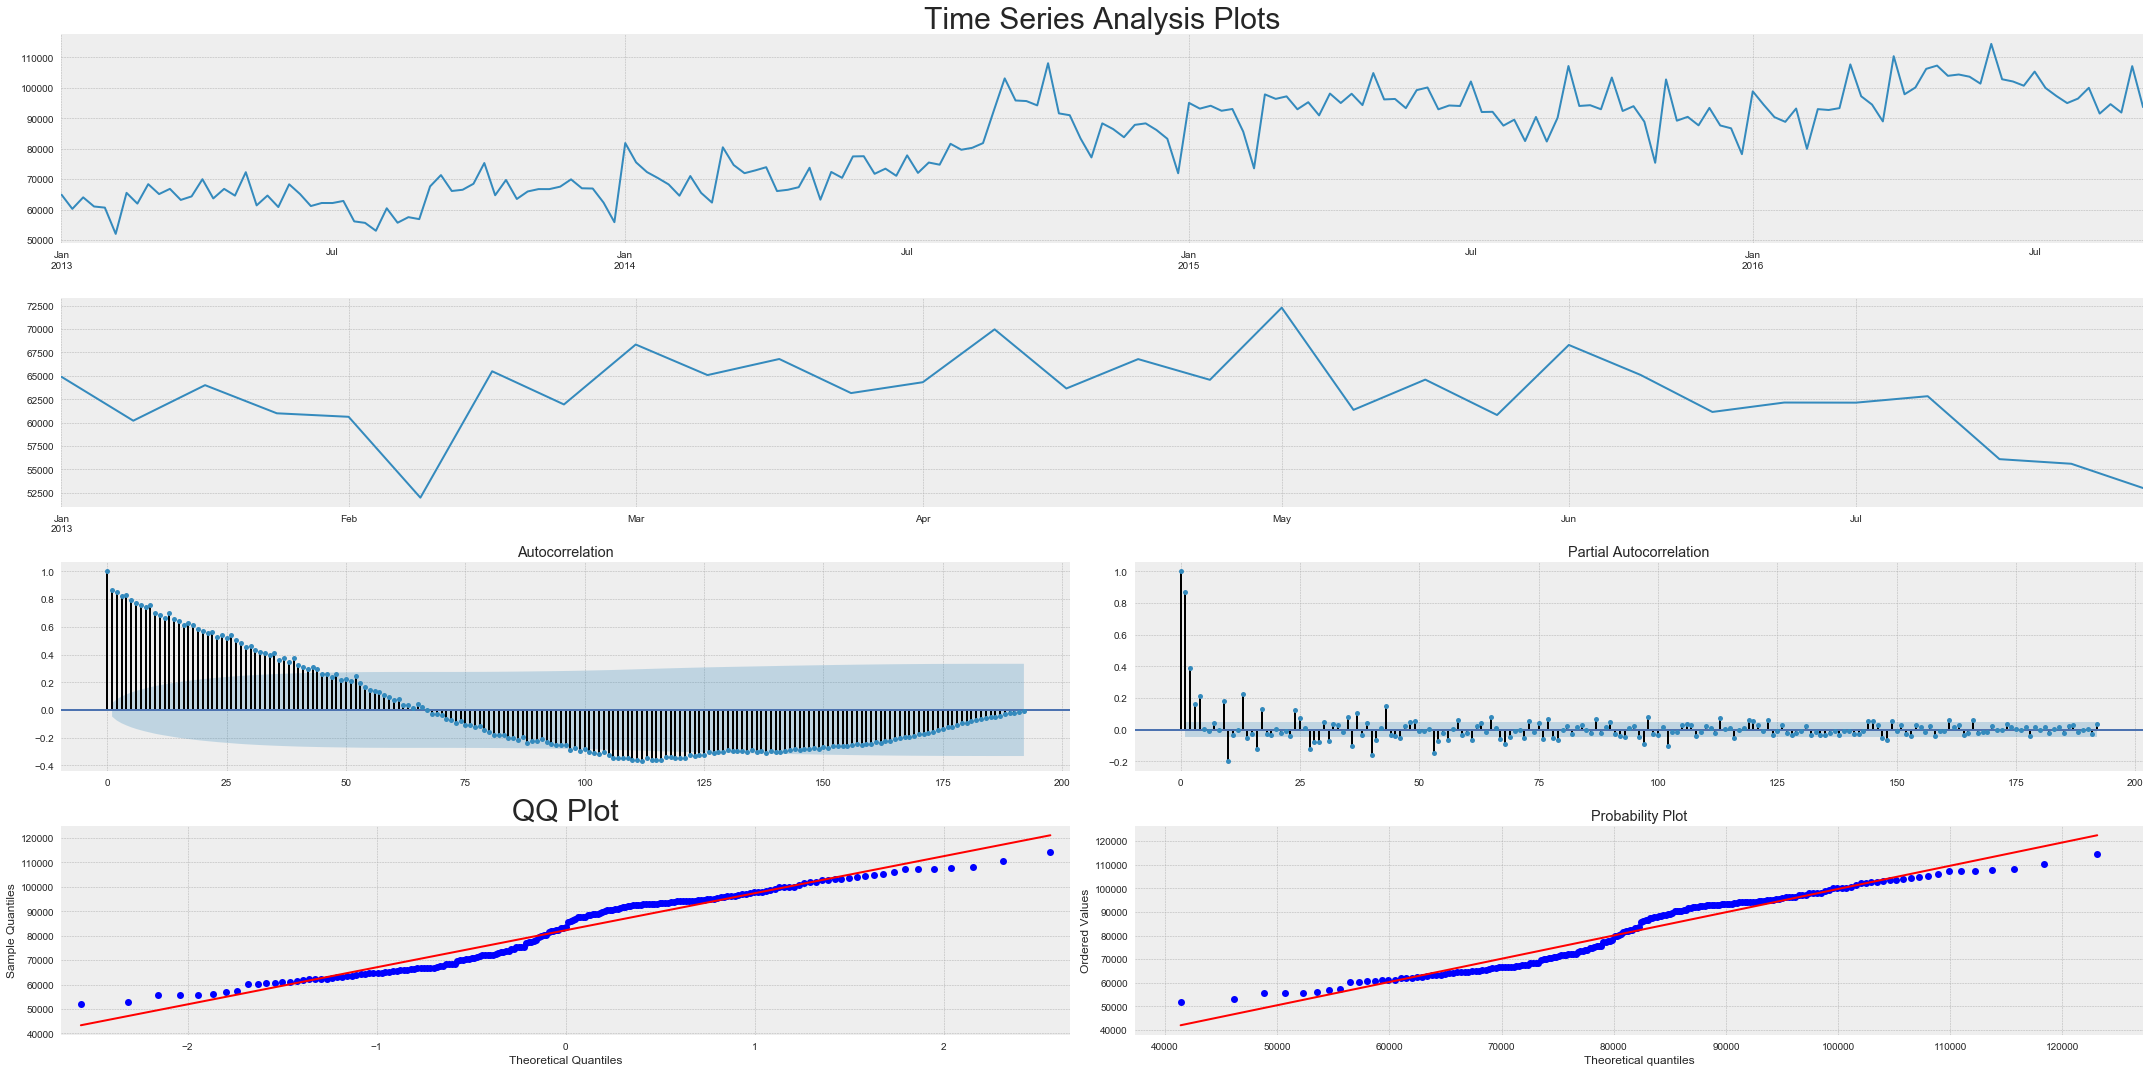

In [628]:
# all plots
tsplot(baked_train);

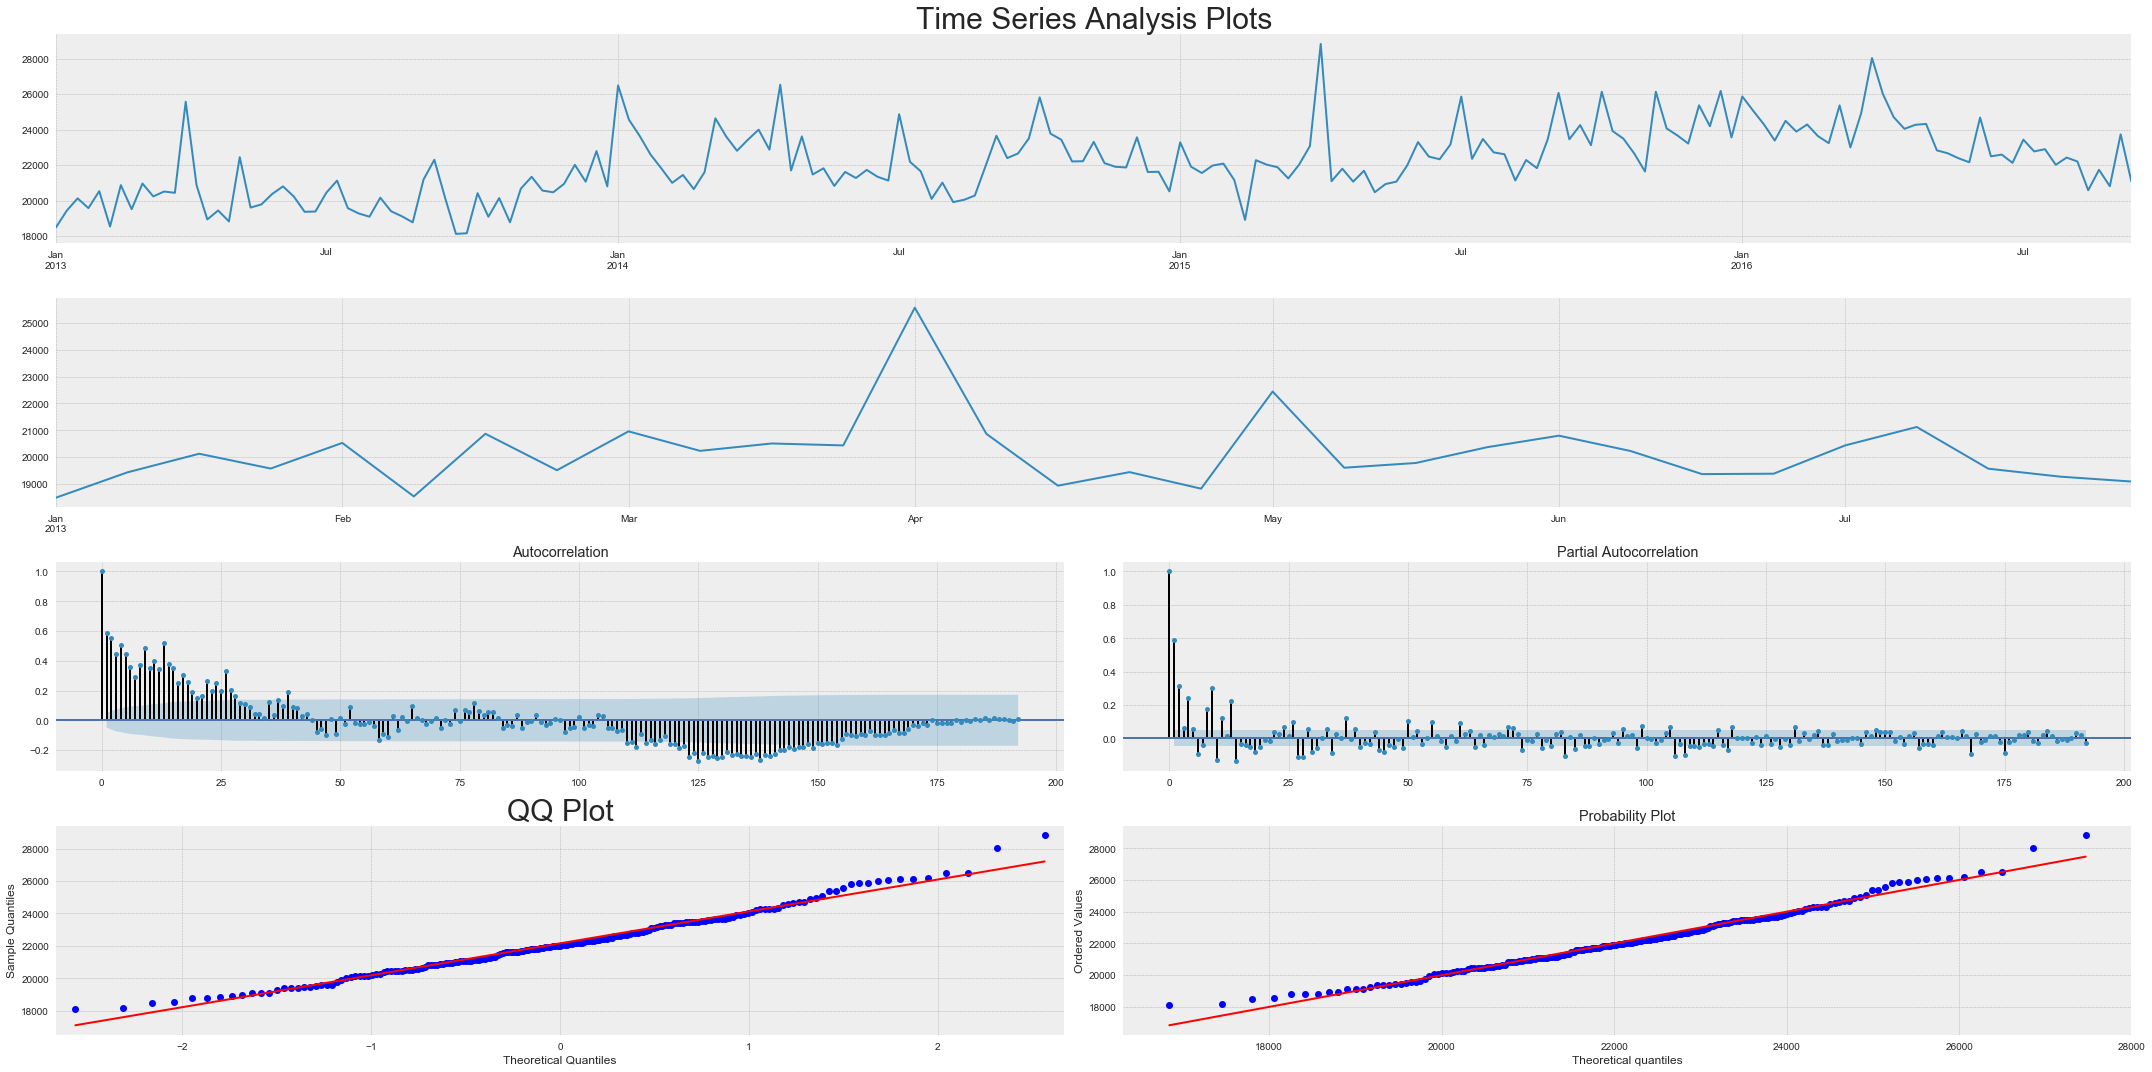

In [629]:
# all plots
tsplot(prepared_train);

The seasonality seems to have gone. But the auto-correlation is still looking a bit weird.
The process probably isn't stationary.
Let's look at the differenciated series.

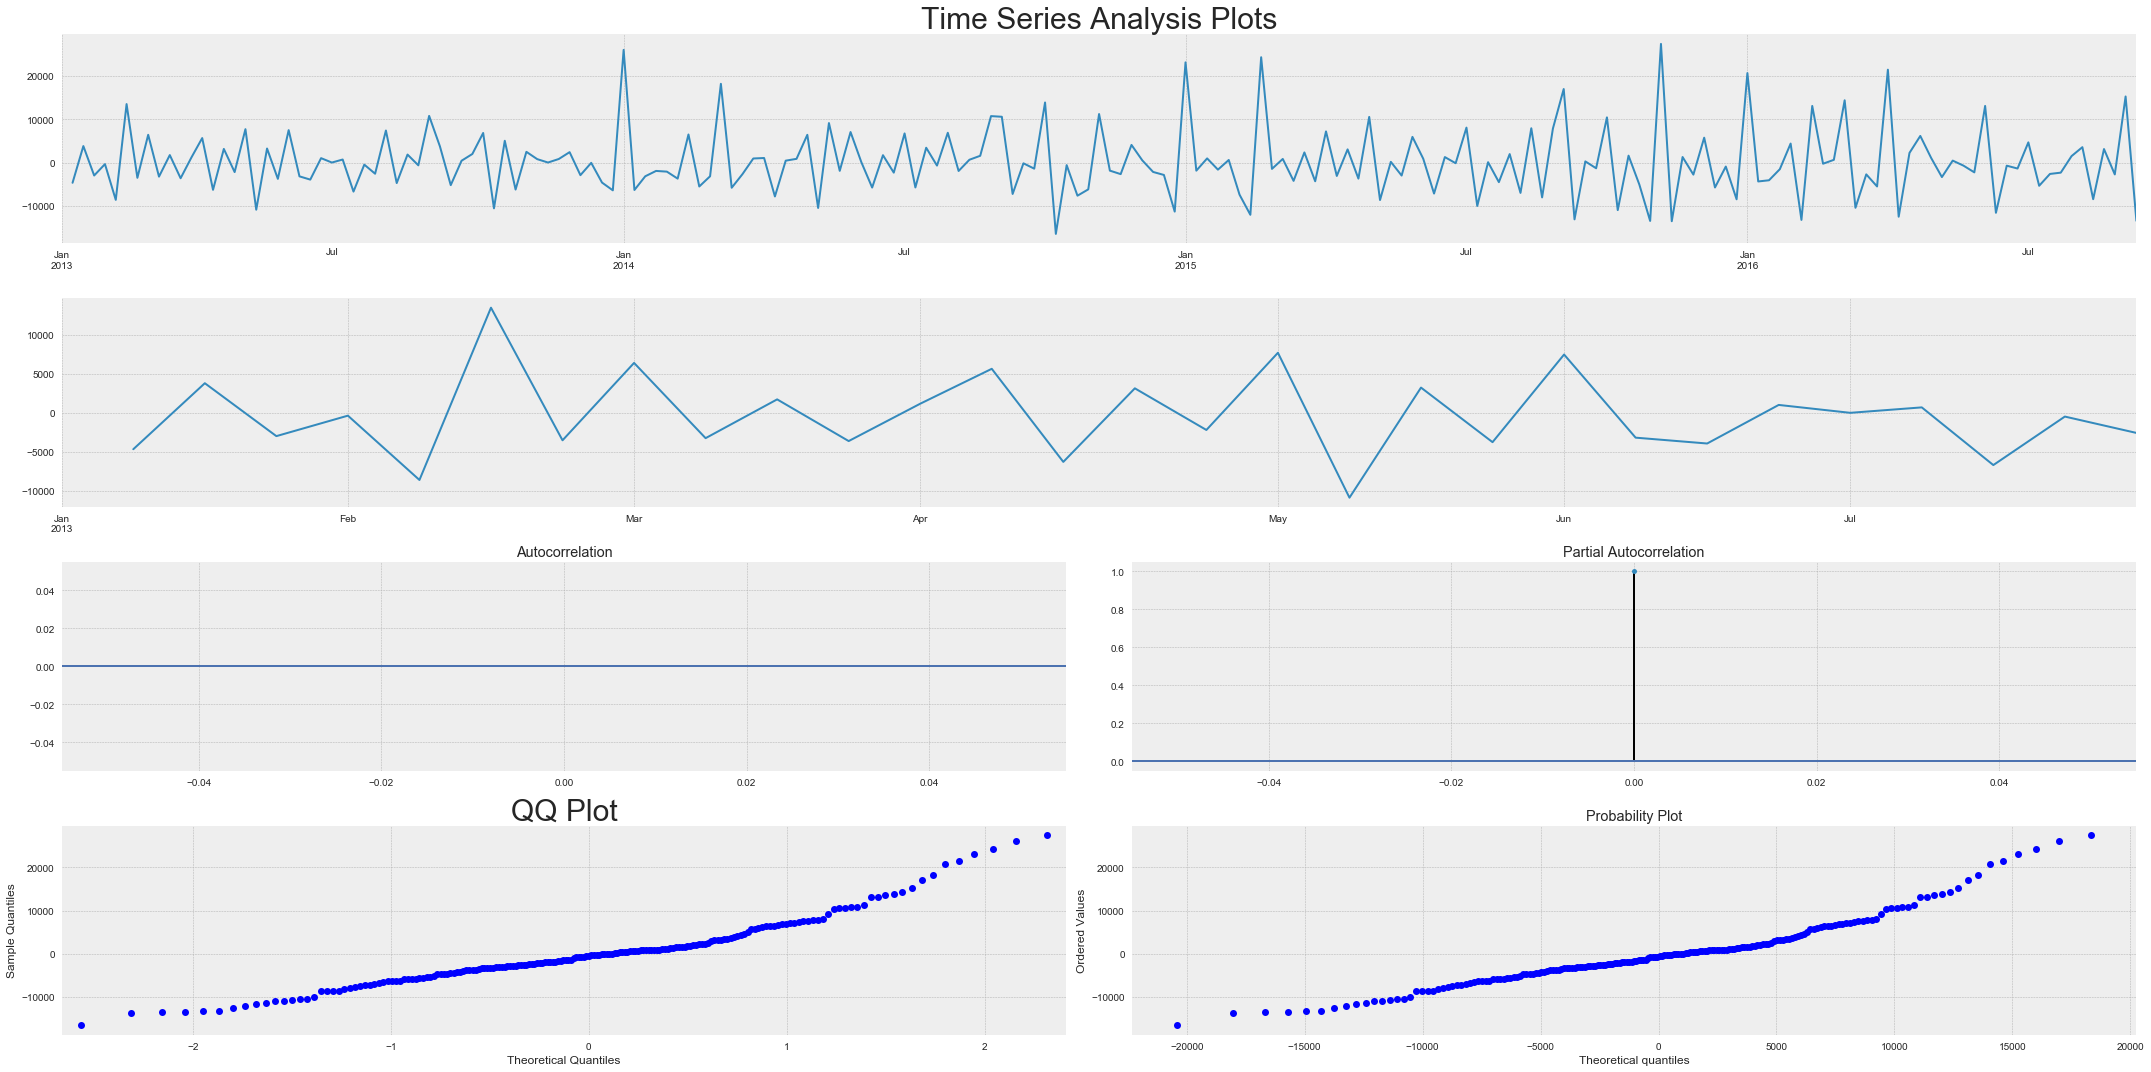

In [630]:
# first order differentiation
tsplot(baked_train.diff())

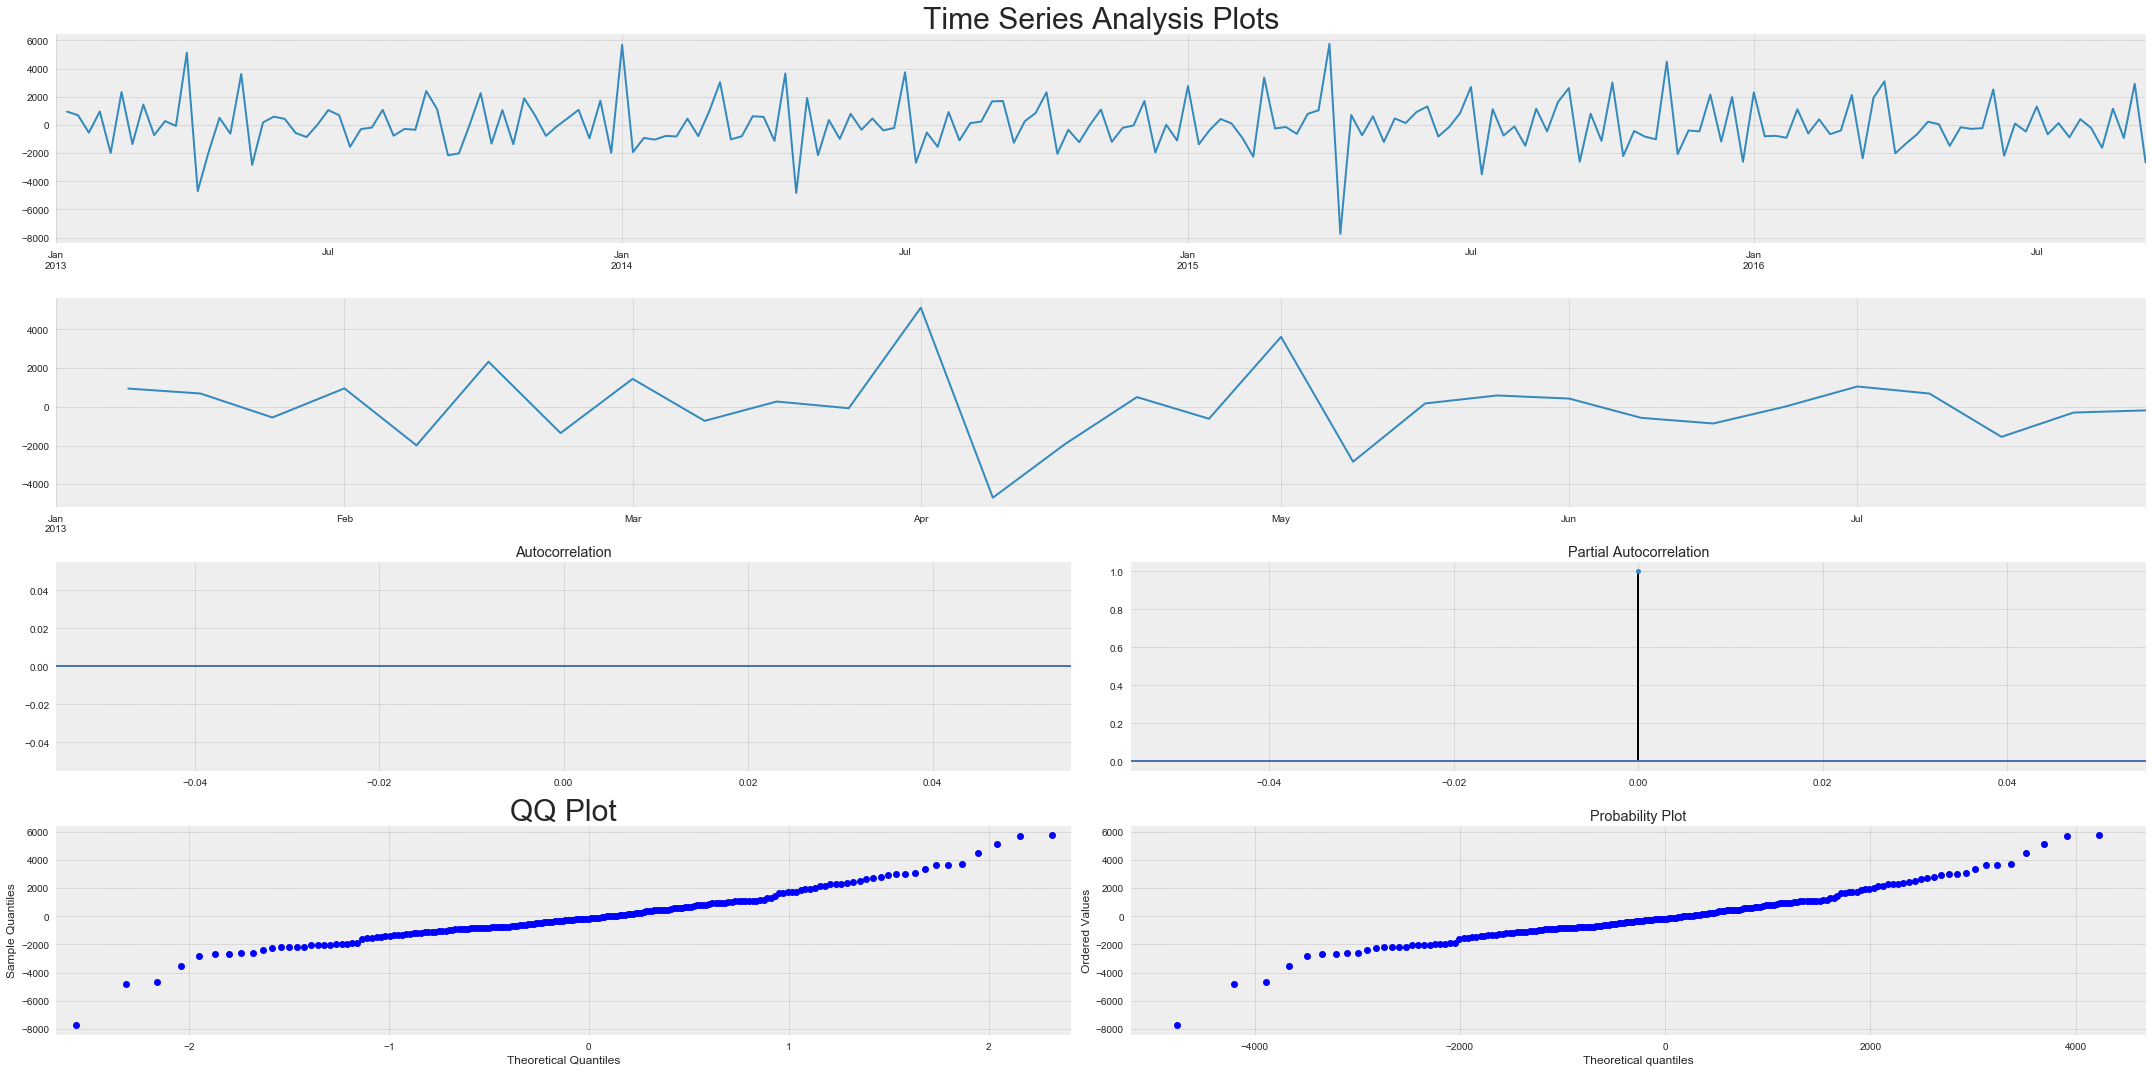

In [631]:
# first order differentiation
tsplot(prepared_train.diff())

We annihilate auto-correlation when differentiating once.
This entices us to explore how an ARIMA could fit our model.
But to simplify our study and for better visualization WE WILL WORK WITH THE DIFFERENTIATED SERIES.
In the following we use statmodels ARMA function to try out different ARMA(p,q) orders. We use the Akaike Information Criterion to order each model's performance. 

In [632]:
# keeping differentiated series as study objects
baked_train = baked_train.diff()
baked_oos = baked_oos.diff()
prepared_train = prepared_train.diff()
prepared_oos = prepared_oos.diff()

## Model Selection

In [653]:
# select best ARIMA model according to AIC
def _get_best_model(TS, max_order=3):
    # best values
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    # fit models
    pq_rng = range(max_order)
    for i in pq_rng:
        for j in pq_rng:
            if (i, j) == (0, 0):
                continue
            tmp_mdl = smt.ARMA(TS, order=(i,j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [634]:
# get rid of overflow warnings
import warnings
warnings.filterwarnings(action='error')

In [654]:
# get Best order for arima
_get_best_model(baked_train[1:]);

aic: 3912.98193 | order: (0, 1)


In [658]:
# get Best order for arima
_get_best_model(prepared_train[1:]);

aic: 3351.83542 | order: (2, 2)


## Model Verification 

let's fit both models and look at residuals.

                              ARMA Model Results                              
Dep. Variable:             unit_sales   No. Observations:                  192
Model:                     ARMA(0, 1)   Log Likelihood               -1954.491
Method:                           mle   S.D. of innovations           6369.146
Date:                Fri, 30 Mar 2018   AIC                           3912.982
Time:                        19:57:45   BIC                           3919.497
Sample:                    01-14-2013   HQIC                          3915.621
                         - 09-12-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ma.L1.unit_sales    -0.6586      0.057    -11.563      0.000      -0.770      -0.547
                                    Roots                                    
                 Real           Ima

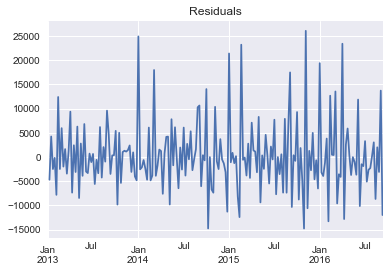

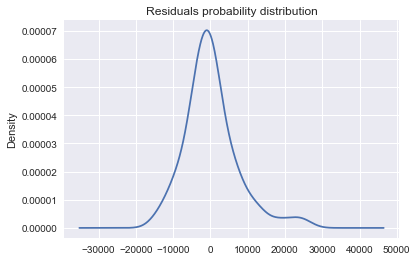

count      192.000000
mean       235.517920
std       7189.422713
min     -14775.474399
25%      -3826.348004
50%       -503.831815
75%       2763.416765
max      26068.187456
dtype: float64


In [662]:
# fit model
baked_model = smt.ARMA(baked_train[1:], order=(0,1))
baked_model_fit = baked_model.fit(method='mle', trend='nc', disp=0)
print(baked_model_fit.summary())
# plot residual errors
baked_values = pd.Series(prepared_model_fit.fittedvalues)
baked_residuals = baked_train - baked_values
baked_residuals.plot()
plt.title('Residuals')
plt.show()
baked_residuals.plot(kind='kde')
plt.title('Residuals probability distribution')
plt.show()
print(baked_residuals.describe())

                              ARMA Model Results                              
Dep. Variable:             unit_sales   No. Observations:                  192
Model:                     ARMA(2, 2)   Log Likelihood               -1670.918
Method:                           mle   S.D. of innovations           1452.872
Date:                Fri, 30 Mar 2018   AIC                           3351.835
Time:                        21:25:57   BIC                           3368.123
Sample:                    01-14-2013   HQIC                          3358.432
                         - 09-12-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1.unit_sales    -0.3334      0.200     -1.664      0.098      -0.726       0.059
ar.L2.unit_sales     0.2714      0.092      2.956      0.004       0.091       0.451
ma.L1.unit_sales    -0.3272 

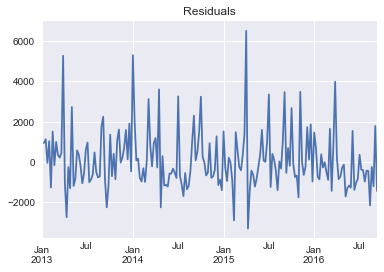

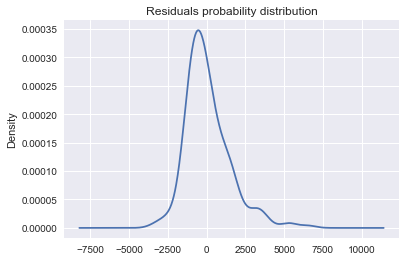

count     192.000000
mean       86.952496
std      1455.824503
min     -3302.146457
25%      -852.691094
50%      -243.949005
75%       731.244762
max      6515.880306
dtype: float64


In [791]:
# fit model
prepared_model = smt.ARMA(prepared_train[1:], order=(2, 2))
prepared_model_fit = prepared_model.fit(method='mle', trend='nc', disp=0)
print(prepared_model_fit.summary())
# plot residual errors
prepared_values = pd.Series(prepared_model_fit.fittedvalues)
prepared_residuals = prepared_train - prepared_values
prepared_residuals.plot()
plt.title('Residuals')
plt.show()
prepared_residuals.plot(kind='kde')
plt.title('Residuals probability distribution')
plt.show()
print(prepared_residuals.describe())

This was announced by the QQ plots of the differenciated series and is confirmed by the plots of our residuals. They look normally distributed. To confirm we can look at ar battery of plots and compute a few Goodness of Fit statistics using the scikit-gof library.

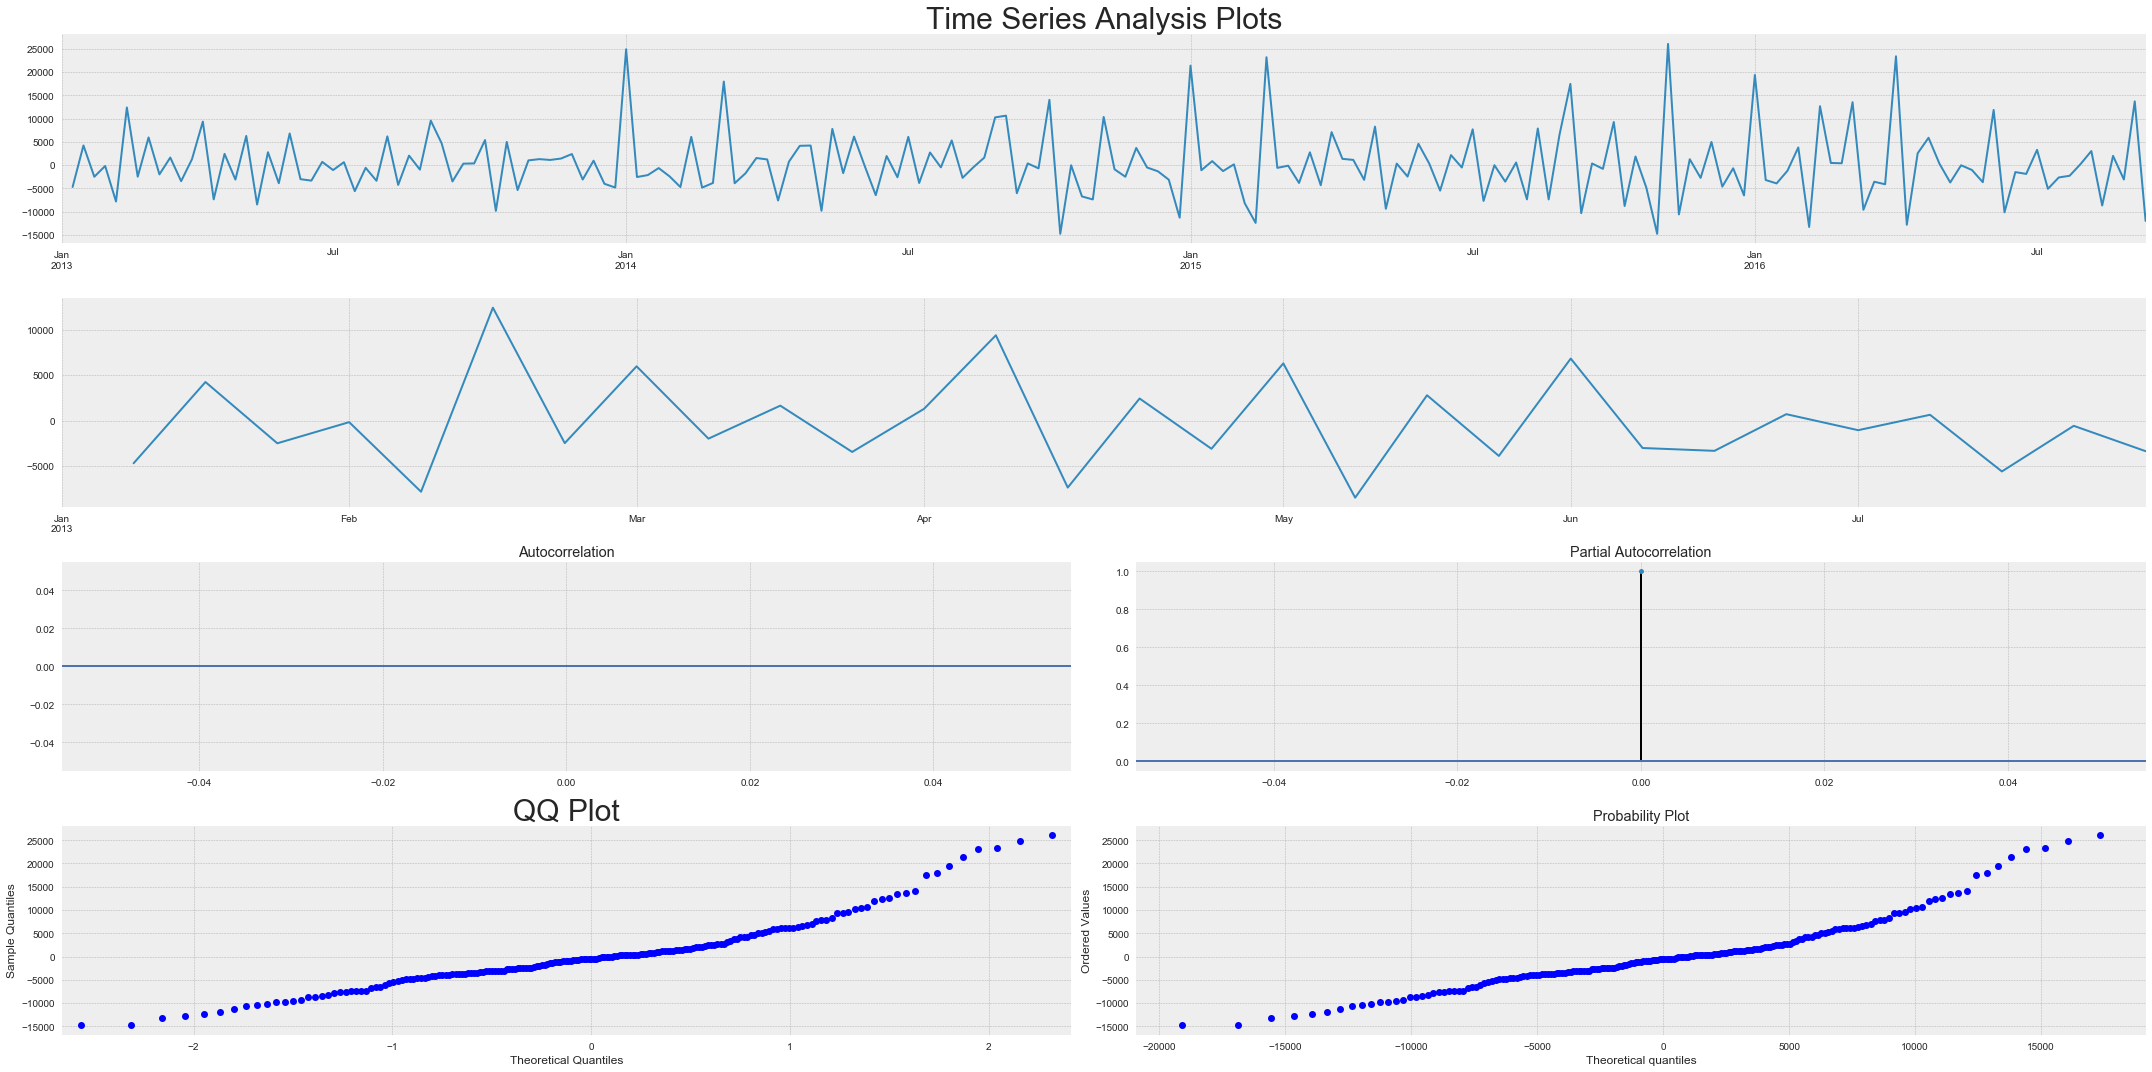

In [665]:
tsplot(baked_residuals)

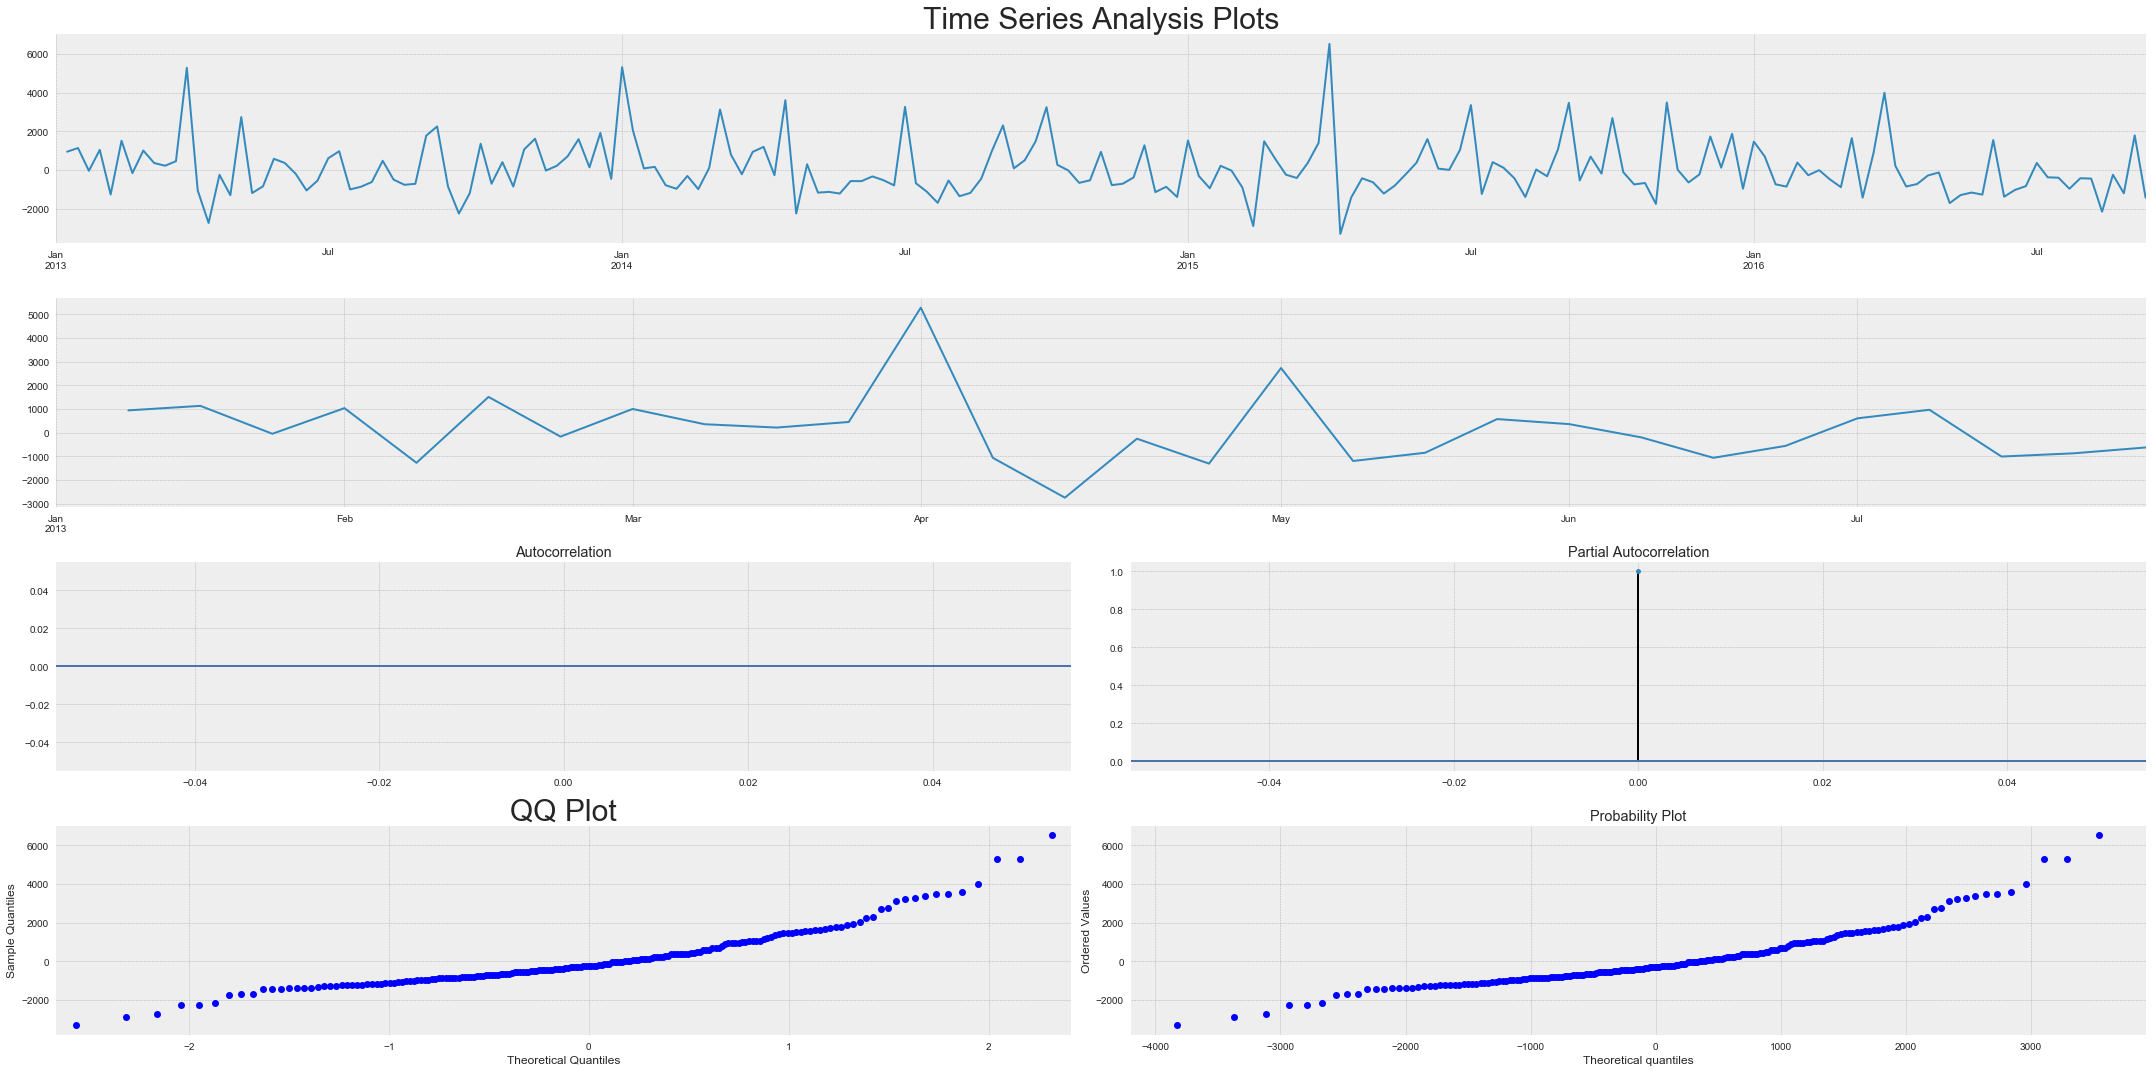

In [666]:
tsplot(prepared_residuals)

Let's look at the goodness of fit statistics.

In [490]:
from skgof import ks_test, cvm_test

In [667]:
# we might want to standardize
def standardize(series):
    mean = series.mean()
    std = series.std()
    return (series - mean) / std

In [668]:
# Kolmogorov-Smirnov GoF statistic
baked_resid_stdized = standardize(baked_residuals[1:])
print(scs.kstest(baked_resid_stdized, 'norm'))
# Cramer - Von Mises GoF statistic
print(cvm_test(baked_resid_stdized, 'norm'))

KstestResult(statistic=0.12052393574701981, pvalue=0.0068936748879675491)
GofResult(statistic=0.60587707182212136, pvalue=0.021542087079929995)


In [669]:
# Kolmogorov-Smirnov GoF statistic
prep_resid_stdized = standardize(prepared_residuals[1:])
print(scs.kstest(prep_resid_stdized, 'norm'))
# Cramer - Von Mises GoF statistic
print(cvm_test(prep_resid_stdized, 'norm'))

KstestResult(statistic=0.11610419359998814, pvalue=0.010352669936356085)
GofResult(statistic=0.80725542806600681, pvalue=0.0069590311385951953)


The obtained p-values are evidence against the normal distribution of residues for both baked and prepared foods. Thus we will want to continue our modeling effort and consider a volatility process.

## Predictive benchmark

We here take a look at the predictive performance of our ARMA models.
We'll do some in-sample forecasting as well as some out-sample forecasting (predicting one by one).

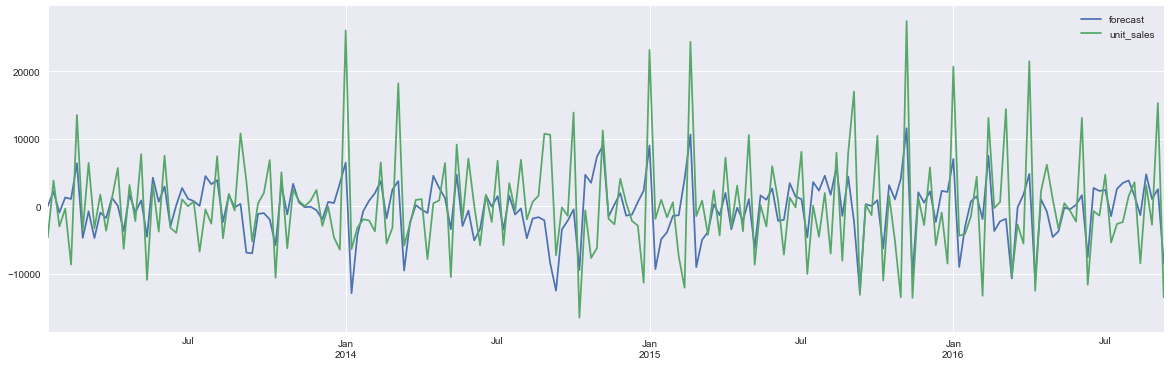

In [680]:
# plot in-sample predictions
plt.figure(figsize=(20, 6))
ax = plt.gca()
baked_model_fit.plot_predict(ax=ax);

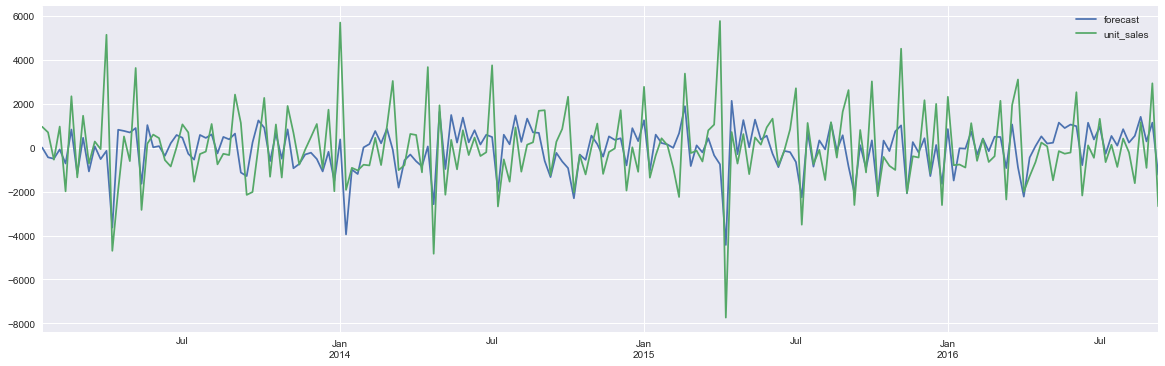

In [681]:
# plot in-sample predictions
plt.figure(figsize=(20, 6))
ax = plt.gca()
prepared_model_fit.plot_predict(ax=ax);

In [792]:
# lentght of OOS sample
oos_len = len(baked_oos)

In [793]:
# predict next weekly sales with arima model, given the simplicity of our models we need to iterate over the 
baked_arima_frcst = []
prepared_arima_frcst = []
baked_insample = [x for x in baked_train[1:]]
prepared_insample = [x for x in prepared_train[1:]]
for i in range(oos_len - 1):
    baked_pred_fit = smt.ARMA(baked_insample, order=(0, 1)).fit(method='mle', trend='nc', disp=0)
    prepared_pred_fit = smt.ARMA(prepared_insample, order=(2, 2)).fit(method='mle', trend='nc', disp=0)
    baked_arima_frcst.append(baked_pred_fit.forecast(alpha=0.05)[0])
    prepared_arima_frcst.append(prepared_pred_fit.forecast(alpha=0.05)[0])
    baked_insample.append(baked_oos[1:].values[i])
    prepared_insample.append(prepared_oos[1:].values[i])

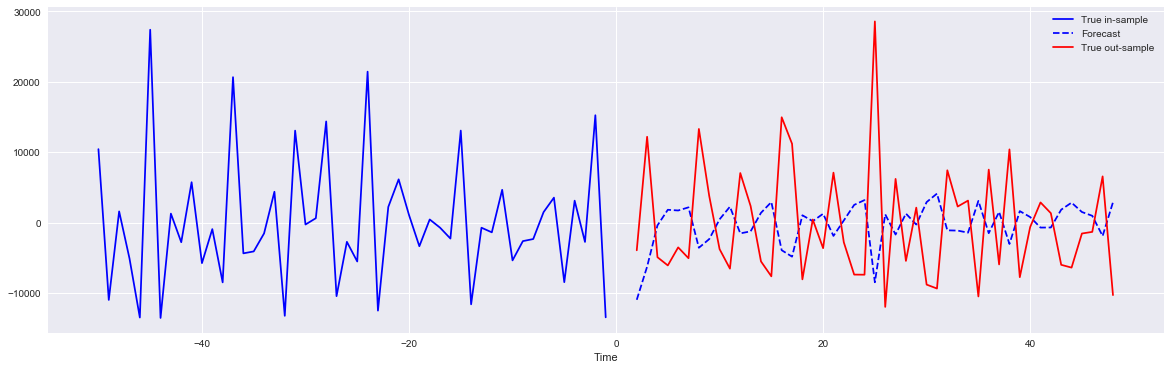

In [698]:
# plotting in-sample then out-of-sample true values and forecast
plt.figure(figsize=(20, 6))
plt.plot(range(-oos_len, 0), baked_train[-oos_len:], 'b-', label='True in-sample')
plt.plot(range(2, oos_len-1), baked_arima_frcst[2:], 'b--', label='Forecast')
plt.plot(range(2, oos_len-1), baked_oos[2:-1], 'r-', label='True out-sample')
plt.xlabel('Time')
plt.legend();

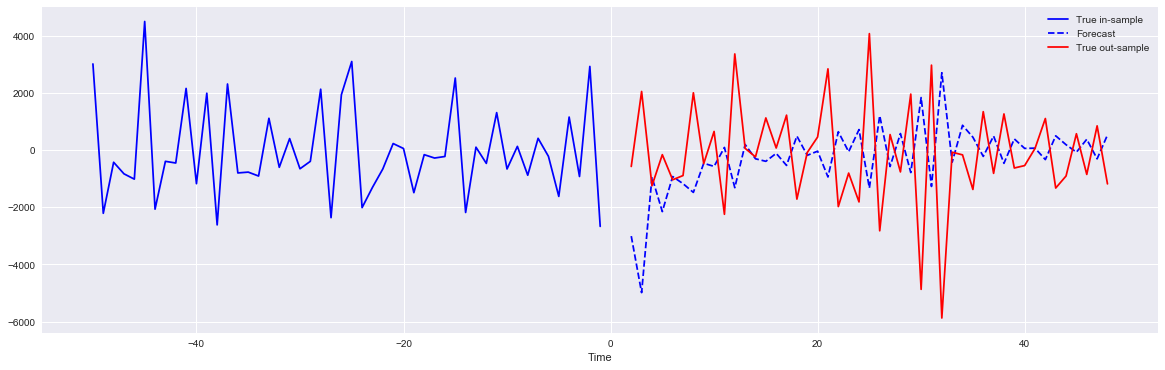

In [700]:
# plotting in-sample then out-of-sample true values and forecast
plt.figure(figsize=(20, 6))
plt.plot(range(-oos_len, 0), prepared_train[-oos_len:], 'b-', label='True in-sample')
plt.plot(range(2, oos_len-1), prepared_arima_frcst[2:], 'b--', label='Forecast')
plt.plot(range(2, oos_len-1), prepared_oos[2:-1], 'r-', label='True out-sample')
plt.xlabel('Time')
plt.legend();

## ARCH motivation : squared residuals

Basically, what we have done previously is modeling the conditional trend. Given that the data doesn't resume to a time-varying trend we now want find a good model for the conditinal volatility.
As a useful approach to volatility modeling we will use ARCH models.
The arch python library will do most of the heavy-lifting for us.
An easy way to identify ARCH-like behaviour is to look if squared residuals show some significance by fitting a AR(p) with them.

In [701]:
# squared residuals
baked_residuals_sqrd = baked_residuals[1:].apply(lambda x: x ** 2)

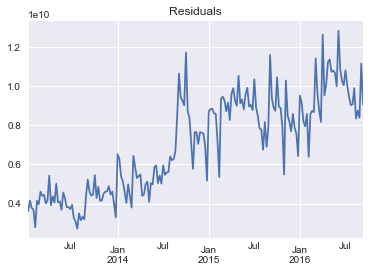

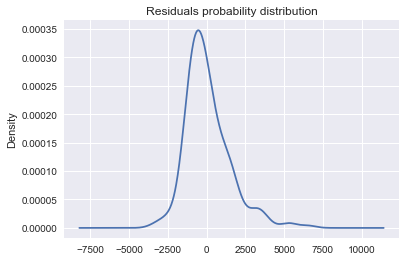

count     192.000000
mean       86.952496
std      1455.824503
min     -3302.146457
25%      -852.691094
50%      -243.949005
75%       731.244762
max      6515.880306
dtype: float64


In [797]:
# fitting AR(p)
p = 1
motiv_model = smt.ARMA(baked_residuals_sqrd, order=(10, 0))
motiv_res = motiv_model.fit(method='mle', trend='nc', disp=0)
motiv_values = pd.Series(prepared_model_fit.fittedvalues)
motiv_residuals = baker_residuals_sqrd - motiv_values
motiv_residuals.plot()
plt.title('Residuals')
plt.show()
prepared_residuals.plot(kind='kde')
plt.title('Residuals probability distribution')
plt.show()
print(prepared_residuals.describe())

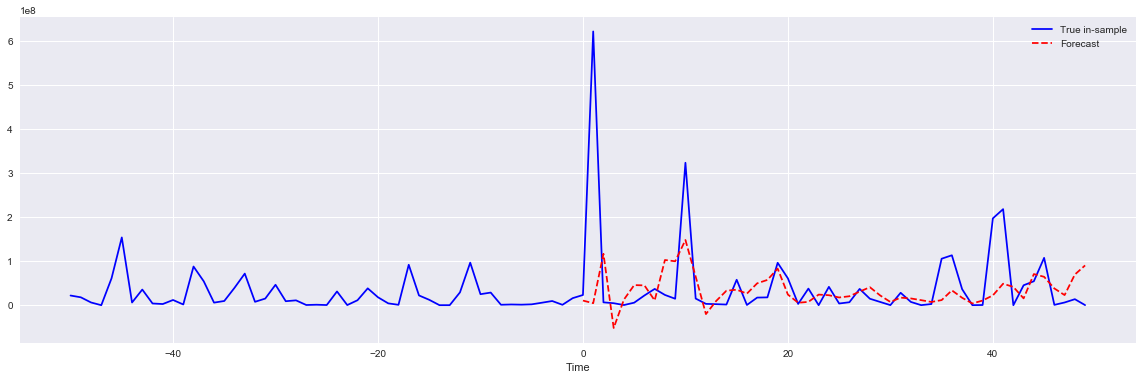

In [704]:
# in sample predictive power
plt.figure(figsize=(20, 6))
size = 50
motiv_frcst = motiv_res.fittedvalues[size: 2 * size]
plt.plot(range(-size, size), baked_residuals_sqrd[:2 * size], 'b-', label='True in-sample')
plt.plot(range(0, size), motiv_frcst, 'r--', label='Forecast')
plt.xlabel('Time')
plt.legend();

This plot seems to show that an ARCH approach has some in-sample preidctive power. This motivates the study of heteroskedacity. To further motivate the GARCH fit we could compute a score statistic under the hypothesis that the GARCH parameters are equal to their estimates. Such a test would indicate the significance of the ARCH modelisation.
For time-related reasons we won't go through this process and directly move on to some modeling.

## Conditional Variance : GARCH model selection

Let's fit and select some GARCH models. We will consider orders up to (2, 2) for both distributions.
We will consider the GJR-GARCH model class that is a little bit less vanilla than GARCH thus often outperforming it.

In [705]:
from itertools import product

In [742]:
# get best GARCH with order up to (2, 2) according to AIC
def _get_best_garch(TS):
    # assymetric lag order
    o = 1
    # all order combinations
    orders = product([1, 2], [1, 2])
    # best values 
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for p, q in orders:
        am = arch_model(TS, mean='zero', p=p, o=1, q=q)
        res = am.fit(update_freq=5, disp='off')
        tmp_aic = res.aic
        if tmp_aic < best_aic:
            best_aic = tmp_aic
            best_order = (p, q)
            best_mdl = res
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [743]:
# optimal orders
aic, order, garch_baked = _get_best_garch(baked_residuals[1:]);

aic: 3936.96901 | order: (1, 1)


In [745]:
# optimal orders
aic, order, garch_prepared = _get_best_garch(prepared_residuals[1:]);

aic: 3349.04764 | order: (1, 1)


We select a GARCH(1, 1) models for both series.

## Modeling : last but not least, overal residual distribution

Up unitl now we have estimated the conidtional mean $\mu_t$ and variance $\sigma_t$ of a model like the following:

\begin{equation*}
I_t = \mu_t(\mathcal{F}_{t-1}) + \sigma_t(\mathcal{F}_{t-1}) \epsilon_t
\end{equation*}
where $\mu_t = \begin{bmatrix} \mu_{tb}\\ \mu_{tp} \end{bmatrix}$ , 
$\sigma_t = \begin{bmatrix} \sigma_{tb}\\ \sigma_{tp} \end{bmatrix}$ and $\epsilon_t = \begin{bmatrix} \epsilon_{tb}\\ \epsilon_{tp} \end{bmatrix}$.

This leaves us with the task of modeling $\epsilon_t$ which is classicaly considered as constantly distributed through time and standardly scaled ($\mu_\epsilon = 0$, $\sigma_\epsilon = 1$).
In the following, to achieve the margin estimation we'll conduct a parametric estimation of the distribution of $\epsilon$. (We could also have used an empirical cdf for some non-parametric estimation)

In fact, we have already implicitely modeled the standardized residuals in the preceding. Indeed when fitting the GARCH model, the function arch_model automatically assumes a normal distribution for the residues.

To explore some other options and try other distribution for $\epsilon$ we can tweak the arch_model function and compare global lokelihoods.

We will do so with the Standard Student's T or the Standardized Skew Student's T.

In [777]:
# fit for all available distributions
baked_res_normal = arch_model(baked_residuals[1:], p=1, o=1, q=1).fit(disp='off')
baked_res_t = arch_model(baked_residuals[1:], p=1, o=1, q=1, dist='t').fit(disp='off')
baked_res_skewt = arch_model(baked_residuals[1:], p=1, o=1, q=1, dist='skewt').fit(disp='off')
baked_lls = pd.Series(OrderedDict((('normal', baked_res_normal.loglikelihood),
                 ('t', baked_res_t.loglikelihood),
                 ('skewt', baked_res_skewt.loglikelihood))))
print(baked_lls)
baked_params = pd.DataFrame(OrderedDict((('normal', baked_res_normal.params),
                 ('t', baked_res_t.params),
                 ('skewt', baked_res_skewt.params))))
print(baked_params)

normal   -1968.174017
t        -1962.349969
skewt    -1955.615269
dtype: float64
                normal             t         skewt
alpha[1]  6.444012e-01  5.953356e-01  5.572537e-01
beta[1]   0.000000e+00  0.000000e+00  0.000000e+00
lambda             NaN           NaN  3.274982e-01
mu        5.602539e+02 -1.501292e+02  9.118738e+01
nu                 NaN  5.059143e+00  6.140566e+00
omega     2.570930e+07  2.570930e+07  2.570929e+07


In [778]:
# final GARCH fit results
baked_res_normal

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.002
Mean Model:             Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:               -1968.17
Distribution:                  Normal   AIC:                           3944.35
Method:            Maximum Likelihood   BIC:                           3957.38
                                        No. Observations:                  192
Date:                Fri, Mar 30 2018   Df Residuals:                      188
Time:                        21:14:25   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu           560.2539    380.544      1.472      0.141 

In [785]:
# fit for all available distributions
prepared_res_normal = arch_model(prepared_residuals[2:], mean='zero', p=1, o=1, q=1).fit(disp='off')
prepared_res_t = arch_model(prepared_residuals[1:], mean='zero', p=1, o=1, q=1, dist='t').fit(disp='off')
prepared_res_skewt = arch_model(prepared_residuals[1:], mean='zero', p=1, o=1, q=1, dist='skewt').fit(disp='off')
prepared_lls = pd.Series(OrderedDict((('normal', prepared_res_normal.loglikelihood),
                 ('t', prepared_res_t.loglikelihood),
                 ('skewt', prepared_res_skewt.loglikelihood))))
print(prepared_lls)
prepared_params = pd.DataFrame(OrderedDict((('normal', prepared_res_normal.params),
                 ('t', prepared_res_t.params),
                 ('skewt', prepared_res_skewt.params))))
print(prepared_params)

normal   -1662.122665
t        -1658.254135
skewt    -1642.617845
dtype: float64
                normal             t         skewt
alpha[1]  1.664414e-02  2.946121e-02  1.208700e-01
beta[1]   4.860344e-01  4.853647e-01  3.469943e-01
gamma[1] -1.664414e-02 -2.946121e-02  2.322830e-02
lambda             NaN           NaN  4.849707e-01
nu                 NaN  4.160945e+00  4.060486e+00
omega     1.061176e+06  1.057974e+06  1.057974e+06


In [780]:
# final GARCH fit results
prepared_res_normal

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.005
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1670.52
Distribution:                  Normal   AIC:                           3349.05
Method:            Maximum Likelihood   BIC:                           3362.08
                                        No. Observations:                  192
Date:                Fri, Mar 30 2018   Df Residuals:                      188
Time:                        21:14:50   Df Model:                            4
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.0580e+06  5.119e+05      2.067  3.875e-02 

We end up with a best LL with a normal distribution for our residuals.
In order to visualize our results, let's look at the stanardized residuals distributions for the optimal fit.
<span style="color:red">The omega parameter is through the roof, it seems that we have introduced a problem at some point in the study.
We weren't able to detect it in time. Still, we wanted to include this study as a way to communicate our vision of the usefulnes of copulas. </span>

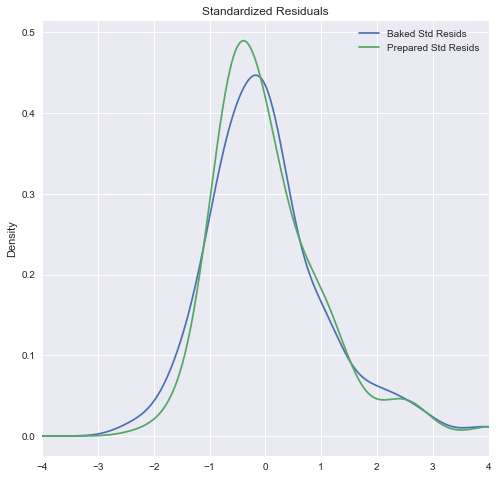

In [781]:
# fetch and estimate standardized residuals
baked_std_resid = baked_res_skewt.resid / baked_res_skewt.conditional_volatility
prepared_std_resid = prepared_res_skewt.resid / prepared_res_skewt.conditional_volatility
df = pd.concat([baked_std_resid, prepared_std_resid],1)
df.columns = ['Baked Std Resids', 'Prepared Std Resids']
df.plot(kind='kde', figsize=(8, 8), xlim=(-4,4), title="Standardized Residuals");

In [782]:
# let's keep track of our different estimates
baked_cmean = baked_values[1:]
baked_cvol = baked_res_skewt.conditional_volatility
baked_resids = baked_res_skewt.resid
prepared_cmean = prepared_values[1:]
prepares_cvol = prepared_res_skewt.conditional_volatility
prepared_resids = prepared_res_skewt.resid

## Predictive Benchmark II

Let's use the whole of our marginal modelisation effort to do some forecasting for OOS sample.
Both the arch (for the conditional variance and standardized residuals) and the statmodels libraries come with implemented forecasting methods.
To better understand how this works for the arch library consider the following notations:

\begin{eqnarray}
  r_t        & =    &\epsilon_t \\
  \epsilon_t & =    & \sigma_t e_t \\
  \sigma^2_t & =    & \omega + \alpha \epsilon_t^2 + \beta \sigma^2_{t-1} \\
  e_t        & \sim & N(0,1)
\end{eqnarray}

Then we get forecasts for $\epsilon_t$ in the "residual_variance" attribute of the output from the forecast() method. 

In [783]:
# generating forecasts
baked_cmean_forecast = baked_arima_frcst[2:]
baked_arch_forecast = baked_res_skewt.forecast(horizon=oos_len, method='simulation')
baked_cvar_resid_forecast = baked_arch_forecast.residual_variance.iloc[-1, :]
baked_forecast = baked_cmean_forecast + baked_cvar_resid_forecast[3:]
prepared_cmean_forecast = prepared_arima_frcst[2:]
prepared_arch_forecast = prepared_res_skewt.forecast(horizon=oos_len, method='simulation')
prepared_cvar_resid_forecast = prepared_arch_forecast.residual_variance.iloc[-1, :]
prepared_forecast = prepared_cmean_forecast + prepared_cvar_resid_forecast[3:]

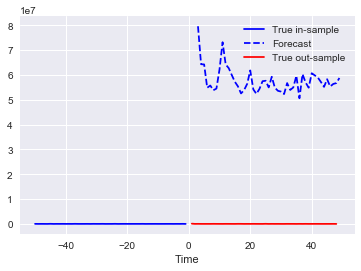

In [766]:
# plotting in-sample then out-of-sample true values and forecast
plt.plot(range(-oos_len, 0), baked_train[-oos_len:], 'b-', label='True in-sample')
plt.plot(range(3, oos_len), baked_forecast, 'b--', label='Forecast')
plt.plot(range(1, oos_len-1), baked_oos[1:-1], 'r-', label='True out-sample')
plt.xlabel('Time')
plt.legend();

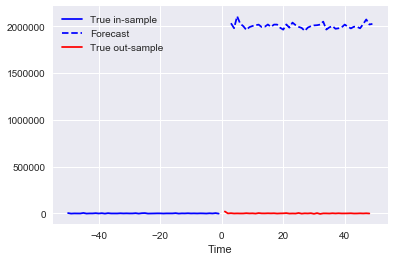

In [795]:
# plotting in-sample then out-of-sample true values and forecast
plt.plot(range(-oos_len, 0), prepared_train[-oos_len:], 'b-', label='True in-sample')
plt.plot(range(3, oos_len), prepared_forecast, 'b--', label='Forecast')
plt.plot(range(1, oos_len-1), prepared_oos[1:-1], 'r-', label='True out-sample')
plt.xlabel('Time')
plt.legend();

<span style="color:red">The omega parameter is through the roof, it seems that we have introduced a problem at some point in the study. Or maybe the GARCH approach isn't the right one here and we were mislead by our regression of the squared residuals.
We weren't able to detect it in time. Still, we wanted to include this study as a way to communicate our vision of the usefulnes of copulas. </span>

#  Dependence examination

Now that we have our margins. We can focus on modeling the dependency structure.

There several well-known copulas out there but thay don't all capture the same dependencies.
In order to study the right ones we want to get a feel for our data's depenencies. 
In the following, we'll be looking at various quantities that point out dependencies on different levels.
Through the copula approach, we'll easily access quantities such as Spearman's rank correlation coefficient or Kendall's tau rank association coefficient. We will also be lookig at quantile dependencies and tail dependencies in the joint distribution, using different copulas.

## Kendal-tau rank correlation

Kendal's rank correlation $\tau$ is a correlation coefficient that measures ordinal similiraty between two data sets. Contrary to Pearson's correlation coefficient, it does not look for linearity. It evaluates if there is a strong relationship between the two rankings of the input sets.
It is defined through the following : 
\begin{equation}
\small
\tau = \frac{(\text{number of concordant pairs}) - (\text{number of discordant pairs})}{n (n-1) /2}
\end{equation}
The version computed in the following is taken in the scipy library and actually computes a slightly altered form of $\tau$ that accounts for ties.
The scipy implementation also outputs a p-value for the null hypothesis that there is no association : $\tau = 0$.
A p-value represents the probability, under the null, of observing a more extreme value of the statistic.
The smaller the p-value the more significant the stat test with regards to the null.

Ironically enough, we didn't have the time to develop this part because of the time we spent on modeling the margins and because we didn't find any reliable python distributions that implemented copula-related features.
The idea was to try to capture in our predictions the dependency between our two series. Possibly improving on the way there.